In [1]:
pwd

'/data/home/ha24521/DL/thyroid_ultrasound_segmentation'

Please open the table of contents — it will help clarify the overall structure.

# 4 base-line segmentation architecture

The initial three architectures are located in `DL/6_segmentation_architecture_1.ipynb`. Please run that notebook before proceeding.  
## 1/4: MobileViT
## 2/4: transUnet
## 3/4: Attention U-Net
## 4/4: U-Net
Here we need `DL/ozan_oktay_Attention_UNet/models/networks/unet_2D.py`

### 4.1 train model

In [4]:
import argparse
import os
from collections import OrderedDict
from glob import glob
import pandas as pd

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F

import yaml
import albumentations as A
from albumentations.core.composition import Compose, OneOf  # version of albumentaation 1.3.1
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
from albumentations import RandomRotate90,Resize
import numpy as np
import random

import sys
sys.path.append('./src')
import archs
import losses
from metrics import iou_score
from utils import AverageMeter, str2bool
from dataset import Dataset

from ozan_oktay_Attention_UNet.models.networks.unet_2D import unet_2D 


def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name: (default: arch)')
    parser.add_argument('--epochs', default=500, type=int, metavar='N',   
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=4, type=int,
                        metavar='N', help='mini-batch size (default: 16)')
    
    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='Axial')   
    parser.add_argument('--deep_supervision', default=False, type=str2bool)
    parser.add_argument('--input_channels', default=3, type=int,           
                        help='input channels')
    parser.add_argument('--num_classes', default=1, type=int,              
                        help='number of classes')
    parser.add_argument('--input_w', default=224, type=int,                
                        help='image width')
    parser.add_argument('--input_h', default=224, type=int,
                        help='image height')
    
    # loss
    parser.add_argument('--loss', default='BCEDiceLoss',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: BCEDiceLoss)')
    
    # dataset
    parser.add_argument('--dataset', default='ICOS',
                        help='dataset name')
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    parser.add_argument('--mask_ext', default='.jpg',
                        help='mask file extension')

    # optimizer
    parser.add_argument('--optimizer', default='Adam',
                        choices=['Adam', 'SGD'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD']) +
                        ' (default: Adam)')
    parser.add_argument('--lr', '--learning_rate', default=1e-3, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')

    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-5, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.1, type=float)
    parser.add_argument('--patience', default=2, type=int)
    parser.add_argument('--milestones', default='1,2', type=str)
    parser.add_argument('--gamma', default=2/3, type=float)
    parser.add_argument('--early_stopping', default=-1, type=int,
                        metavar='N', help='early stopping (default: -1)')
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', )

    parser.add_argument('--num_workers', default=4, type=int)

    config = parser.parse_args()

    return config


# args = parser.parse_args()
def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target in train_loader:     
        input = input.cuda()
        target = target.cuda()
        target = target.unsqueeze(1)

        # compute output
        if config['deep_supervision']:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou,dice = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou,dice = iou_score(output, target)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target in val_loader:     
            input = input.cuda()
            target = target.cuda()
            target = target.unsqueeze(1)

            # compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou,dice = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou,dice = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))
            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, mask):
        weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
        wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
        wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

        pred = torch.sigmoid(pred)
        smooth = 1
        size = pred.size(0)
        pred_flat = pred.view(size, -1)
        mask_flat = mask.view(size, -1)
        intersection = pred_flat * mask_flat
        dice_score = (2 * intersection.sum(1) + smooth) / (pred_flat.sum(1) + mask_flat.sum(1) + smooth)
        dice_loss = 1 - dice_score.sum() / size

        return (wbce + 0.6*dice_loss).mean()


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        
def main():
   
    config = {
    'name': 'unet_test', 
    'epochs': 5, # I recommend 400 epochs for fully demonstrating the potential of transUnet. Here I use 5 epochs to test whether the code runs successfully. 
    'batch_size': 4,
    'arch': 'Axial',
    'deep_supervision': False,
    'input_channels': 3,
    'num_classes': 1,
    'input_w': 224,
    'input_h': 224,
    'loss': 'BCEDiceLoss',
    'dataset': 'ICOS',
    'img_ext': '.jpg',
    'mask_ext': '.jpg',
    'optimizer': 'Adam',
    
    'lr': 1e-3,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'nesterov': False,
    'scheduler': 'CosineAnnealingLR',
    'min_lr': 1e-5,
    'factor': 0.1,
    'patience': 2,
    'milestones': '1,2',
    'gamma': 2/3,
    'early_stopping': -1,   
    'num_workers': 4
}
    set_seed(42)
    
    if config['name'] is None:
        if config['deep_supervision']:
            config['name'] = '%s_%s_wDS' % (config['dataset'], config['arch'])
        else:
            config['name'] = '%s_%s_woDS' % (config['dataset'], config['arch'])
    
    os.makedirs('models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    with open('models/%s/config.yml' % config['name'], 'w') as f:
        yaml.dump(config, f)

    # define loss function (criterion)
    if config['loss'] == 'BCEDiceLoss':
        criterion = BCEDiceLoss().cuda() #nn.BCEWithLogitsLoss().cuda()
    else:
        criterion = losses.__dict__[config['loss']]().cuda()
    cudnn.benchmark = True

    model = unet_2D(n_classes=1, in_channels=3)        
    model = model.cuda()

    params = filter(lambda p: p.requires_grad, model.parameters())

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print ("\nTrainable parameters", pytorch_total_params)
    
    # print(params)
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(
            params, lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
                              nesterov=config['nesterov'], weight_decay=config['weight_decay'])
    else:
        raise NotImplementedError

    if config['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
    elif config['scheduler'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=config['factor'], patience=config['patience'],
                                                   verbose=1, min_lr=config['min_lr'])
    elif config['scheduler'] == 'MultiStepLR':
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(e) for e in config['milestones'].split(',')], gamma=config['gamma'])
    elif config['scheduler'] == 'ConstantLR':
        scheduler = None
    else:
        raise NotImplementedError

    # Data loading code
    train_img_ids = glob('dataset_TN3K/training_image/*')
    train_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in train_img_ids]

    val_img_ids = glob('dataset_TN3K/validation_image/*')
    val_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in val_img_ids]
    

    train_transform = Compose([
        RandomRotate90(),
        A.HorizontalFlip(), 
        A.VerticalFlip(),   
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=45, p=0.75),
        A.Transpose(),
        Resize(config['input_h'], config['input_w']), 
        A.Normalize(),
    ])

    val_transform = Compose([
        Resize(config['input_h'], config['input_w']),
        A.Normalize(),
    ])

    train_dataset = Dataset(
        img_ids=train_img_ids,
        img_dir='dataset_TN3K/training_image',
        mask_dir='dataset_TN3K/training_mask',
        
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=train_transform)
    
    val_dataset = Dataset(
        img_ids=val_img_ids,
        img_dir=os.path.join('dataset_TN3K/validation_image'),
        mask_dir=os.path.join('dataset_TN3K/validation_mask'),
        
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=val_transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        drop_last=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False)
    log = OrderedDict([
        ('epoch', []),
        ('lr', []),
        ('loss', []),
        ('iou', []),
        ('val_loss', []),
        ('val_iou', []),
        ('val_dice', []),
    ])

    best_iou = 0
    trigger = 0
    for epoch in range(config['epochs']):
        print('Epoch [%d/%d]' % (epoch, config['epochs']))

        # train for one epoch
        train_log = train(config, train_loader, model, criterion, optimizer)
        # evaluate on validation set
        val_log = validate(config, val_loader, model, criterion)

        if config['scheduler'] == 'CosineAnnealingLR':
            scheduler.step()
        elif config['scheduler'] == 'ReduceLROnPlateau':
            scheduler.step(val_log['loss'])

        print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

        
        log['epoch'].append(epoch)   
        log['lr'].append(optimizer.param_groups[0]['lr'])       
        print(f"Current LR: {optimizer.param_groups[0]['lr']}") 
        
        log['loss'].append(train_log['loss'])
        log['iou'].append(train_log['iou'])
        log['val_loss'].append(val_log['loss'])
        log['val_iou'].append(val_log['iou'])
        log['val_dice'].append(val_log['dice'])

        pd.DataFrame(log).to_csv('models/%s/log.csv' %
                                 config['name'], index=False)

        trigger += 1

        if val_log['iou'] > best_iou:
            torch.save(model.state_dict(), 'models/%s/model.pth' %
                       config['name'])
            best_iou = val_log['iou']
            print("=> saved best model")
            trigger = 0

        # early stopping
        if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
            print("=> early stopping")
            break

        torch.cuda.empty_cache()


if __name__ == '__main__':
    main()


--------------------
name: unet_test
epochs: 5
batch_size: 4
arch: Axial
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 224
input_h: 224
loss: BCEDiceLoss
dataset: ICOS
img_ext: .jpg
mask_ext: .jpg
optimizer: Adam
lr: 0.001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
num_workers: 4
--------------------

Trainable parameters 2465329
Epoch [0/5]


  0%|          | 0/575 [00:00<?, ?it/s]/data/home/ha24521/.conda/envs/Practical_5/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 144/144 [00:02<00:00, 70.91it/s, loss=0.762, iou=0.223, dice=0.352]


loss 0.8526 - iou 0.0509 - val_loss 0.7615 - val_iou 0.2225
Current LR: 0.000905463412215599
=> saved best model
Epoch [1/5]


100%|██████████| 144/144 [00:01<00:00, 123.06it/s, loss=0.754, iou=0.297, dice=0.447]


loss 0.7524 - iou 0.2627 - val_loss 0.7539 - val_iou 0.2966
Current LR: 0.000657963412215599
=> saved best model
Epoch [2/5]


100%|██████████| 144/144 [00:01<00:00, 121.98it/s, loss=0.699, iou=0.362, dice=0.521]


loss 0.6903 - iou 0.3281 - val_loss 0.6987 - val_iou 0.3624
Current LR: 0.0003520365877844011
=> saved best model
Epoch [3/5]


100%|██████████| 144/144 [00:01<00:00, 121.45it/s, loss=0.609, iou=0.415, dice=0.574]


loss 0.6585 - iou 0.3704 - val_loss 0.6094 - val_iou 0.4147
Current LR: 0.00010453658778440106
=> saved best model
Epoch [4/5]


100%|██████████| 144/144 [00:01<00:00, 128.80it/s, loss=0.585, iou=0.397, dice=0.547]


loss 0.6041 - iou 0.4082 - val_loss 0.5847 - val_iou 0.3966
Current LR: 1e-05


### 4.2 calculate IoU and Dice
unet_test  
dataset_TN3K

In [12]:
from dataset_alt import Dataset
import numpy as np
import random

from ozan_oktay_Attention_UNet.models.networks.unet_2D import unet_2D 


def validate_and_predict(config, test_loader, model, criterion, output_dir):
    avg_meters = {'loss': AverageMeter(), 
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        pbar = tqdm(total=len(test_loader), desc="Validating and Predicting")
        for i, (input, target, metadata) in enumerate(test_loader):
            img_id = metadata['img_id'][0] 

            input = input.cuda()
            target = target.cuda()
            target_original_shape = target.shape[1:] # Get H, W of original mask
            target = target.unsqueeze(1)             # Add channel dimension

            # Print original image and mask sizes
            print(f"\nProcessing image ID: {img_id}") 
            print(f"Input ultrasound image size (H, W): {input.shape[2:]}")
            print(f"Ground truth mask size (H, W): {target_original_shape}")

            # Compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                output = outputs[-1] # Use the last output for final prediction
            else:
                output = model(input)
                loss = criterion(output, target)

            output = F.interpolate(output, size=target_original_shape, mode="bilinear", align_corners=False)

            iou, dice = iou_score(output, target) 

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)

            # Save prediction mask
            pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0] # Take first image in batch, first channel
            # pred_mask = pred_mask>0.5   
            pred_mask[pred_mask>=0.5]=1   
            pred_mask[pred_mask<0.5]=0
            
            pred_mask = (pred_mask * 255).astype(np.uint8)
            predicted_image = Image.fromarray(pred_mask)
            predicted_image.save(os.path.join(output_dir, f"{img_id}_pred.jpg"))

        pbar.close()
    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

    
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, mask):
        # mask = mask.unsqueeze(dim=1)
        weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
        wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
        wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

        pred = torch.sigmoid(pred)
        smooth = 1
        size = pred.size(0)
        pred_flat = pred.view(size, -1)
        mask_flat = mask.view(size, -1)
        intersection = pred_flat * mask_flat
        dice_score = (2 * intersection.sum(1) + smooth) / (pred_flat.sum(1) + mask_flat.sum(1) + smooth)
        dice_loss = 1 - dice_score.sum() / size

        return (wbce + 0.6*dice_loss).mean()


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def main():
    set_seed(42)
    
    # Load the configuration used for training
    config_path = 'models/unet_test/config.yml' 
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    print('-' * 20)
    print("Loaded training configuration:")
    for key in config:
        print(f'{key}: {config[key]}')
    print('-' * 20)

    # Define loss function (criterion) - must match training
    if config['loss'] == 'BCEDiceLoss':
        criterion = BCEDiceLoss().cuda()
    else:
        # Assuming other losses are defined in losses.py
        criterion = losses.__dict__[config['loss']]().cuda()
    cudnn.benchmark = True

    # Create model and load trained weights
    model = unet_2D(n_classes=1, in_channels=3) 
    model = model.cuda()

    model_path = 'models/unet_test/model.pth' 
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Successfully loaded model weights from {model_path}")
    else:
        print(f"Error: Model weights not found at {model_path}. Please ensure the training was successful.")
        return

    # Data loading code for test set
    test_img_dir = 'dataset_TN3K/test-image'
    test_mask_dir = 'dataset_TN3K/test-mask'

    test_img_ids = glob(os.path.join(test_img_dir, f'*{config["img_ext"]}'))
    test_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in test_img_ids]

    if not test_img_ids:
        print(f"No test images found in {test_img_dir}. Please check the path and extension.")
        return

    test_transform = Compose([
        A.Resize(config['input_h'], config['input_w']), # Resize for model input
        A.Normalize(),
    ])

    test_dataset = Dataset(
        img_ids=test_img_ids,
        img_dir=test_img_dir,
        mask_dir=test_mask_dir,
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=test_transform
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1, # Use batch size 1 for validation to easily handle individual image saving and logging
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False
    )

    output_prediction_dir = 'models/unet_test/predictions'  
    print(f"\nStarting evaluation and prediction saving to: {output_prediction_dir}")
    val_log = validate_and_predict(config, test_loader, model, criterion, output_prediction_dir)

    print(f"\n--- Evaluation Results ---")
    print(f"Test Loss: {val_log['loss']:.4f}")
    print(f"Test IoU: {val_log['iou']:.4f}")
    print(f"Test Dice: {val_log['dice']:.4f}")
    print(f"Predicted masks saved to {output_prediction_dir}")

if __name__ == '__main__':
    main()

/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/networks_other.py:42: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/networks_other.py:46: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  init.normal(m.weight.data, 1.0, 0.02)
/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/networks_other.py:47: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias.data, 0.0)


--------------------
Loaded training configuration:
arch: Axial
batch_size: 4
dataset: ICOS
deep_supervision: False
early_stopping: -1
epochs: 5
factor: 0.1
gamma: 0.6666666666666666
img_ext: .jpg
input_channels: 3
input_h: 224
input_w: 224
loss: BCEDiceLoss
lr: 0.001
mask_ext: .jpg
milestones: 1,2
min_lr: 1e-05
momentum: 0.9
name: unet_test
nesterov: False
num_classes: 1
num_workers: 4
optimizer: Adam
patience: 2
scheduler: CosineAnnealingLR
weight_decay: 0.0001
--------------------
Successfully loaded model weights from models/unet_test/model.pth

Starting evaluation and prediction saving to: models/unet_test/predictions



Validating and Predicting:   0%|          | 0/614 [00:00<?, ?it/s]/data/home/ha24521/.conda/envs/Practical_5/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

Validating and Predicting:   3%|▎         | 21/614 [00:00<00:15, 38.79it/s, loss=0.655, iou=0.335, dice=0.45] 


Processing image ID: 0183
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0586
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0350
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0073
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0476
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0240
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0366
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:   8%|▊         | 47/614 [00:00<00:06, 85.27it/s, loss=0.631, iou=0.368, dice=0.488]


Processing image ID: 0228
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0534
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0021
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0118
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0424
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0008
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0185
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  12%|█▏        | 71/614 [00:00<00:05, 99.85it/s, loss=0.618, iou=0.36, dice=0.486] 


Processing image ID: 0243
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0410
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0369
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0133
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0536
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0300
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0090
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  15%|█▌        | 94/614 [00:01<00:04, 107.00it/s, loss=0.592, iou=0.396, dice=0.526]


Processing image ID: 0538
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0302
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0299
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0092
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0189
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0495
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0356
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  19%|█▉        | 117/614 [00:01<00:04, 113.64it/s, loss=0.6, iou=0.395, dice=0.526]  


Processing image ID: 0137
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0304
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0481
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0371
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0094
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0497
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0261
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  23%|██▎       | 142/614 [00:01<00:04, 113.53it/s, loss=0.59, iou=0.401, dice=0.532] 


Processing image ID: 0139
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0306
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0080
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0483
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0373
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0540
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0096
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  28%|██▊       | 170/614 [00:01<00:03, 120.06it/s, loss=0.584, iou=0.403, dice=0.534]


Processing image ID: 0015
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0321
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0418
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0308
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0082
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0485
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0375
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  31%|███       | 191/614 [00:01<00:03, 114.05it/s, loss=0.586, iou=0.398, dice=0.528]


Processing image ID: 0017
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0323
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0084
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0390
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0487
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0251
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0377
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  35%|███▌      | 217/614 [00:02<00:03, 117.15it/s, loss=0.587, iou=0.389, dice=0.519]


Processing image ID: 0545
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0268
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0032
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0129
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0435
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0602
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0019
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  40%|███▉      | 244/614 [00:02<00:02, 126.03it/s, loss=0.583, iou=0.383, dice=0.512]


Processing image ID: 0311
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0034
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0437
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0201
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0604
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0088
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0394
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  44%|████▍     | 273/614 [00:02<00:02, 131.91it/s, loss=0.578, iou=0.389, dice=0.519]


Processing image ID: 0380
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0270
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0396
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0160
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0257
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0563
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0147
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  49%|████▊     | 299/614 [00:02<00:02, 129.98it/s, loss=0.574, iou=0.387, dice=0.517]


Processing image ID: 0259
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0565
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0023
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0426
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0149
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0316
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0039
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  53%|█████▎    | 324/614 [00:02<00:02, 126.47it/s, loss=0.568, iou=0.394, dice=0.524]


Processing image ID: 0164
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0567
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0025
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0331
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0428
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0221
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0318
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  57%|█████▋    | 348/614 [00:03<00:02, 126.54it/s, loss=0.568, iou=0.394, dice=0.525]


Processing image ID: 0443
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0610
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0166
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0569
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0027
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0333
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0500
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  61%|██████    | 376/614 [00:03<00:01, 127.74it/s, loss=0.563, iou=0.399, dice=0.528]


Processing image ID: 0042
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0445
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0612
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0168
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0029
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0335
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0502
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  65%|██████▌   | 401/614 [00:03<00:01, 126.09it/s, loss=0.561, iou=0.401, dice=0.529]



Processing image ID: 0337
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0101
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0504
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0098
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0571
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0294
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0155
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  70%|██████▉   | 428/614 [00:03<00:01, 128.32it/s, loss=0.557, iou=0.405, dice=0.533]


Processing image ID: 0103
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0506
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0280
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0170
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0573
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0296
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0060
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  74%|███████▍  | 454/614 [00:03<00:01, 129.15it/s, loss=0.554, iou=0.406, dice=0.534]


Processing image ID: 0105
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0508
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0282
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0172
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0575
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0298
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0062
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  79%|███████▊  | 482/614 [00:04<00:01, 130.79it/s, loss=0.557, iou=0.402, dice=0.531]


Processing image ID: 0107
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0284
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0590
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0451
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0174
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0577
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0341
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  83%|████████▎ | 507/614 [00:04<00:00, 125.88it/s, loss=0.56, iou=0.402, dice=0.531]


Processing image ID: 0109
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0286
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0592
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0050
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0453
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0176
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0579
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  87%|████████▋ | 534/614 [00:04<00:00, 127.67it/s, loss=0.563, iou=0.397, dice=0.526]


Processing image ID: 0191
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0288
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0594
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0052
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0455
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0178
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0345
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  92%|█████████▏| 562/614 [00:04<00:00, 134.10it/s, loss=0.564, iou=0.395, dice=0.525]


Processing image ID: 0596
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0054
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0360
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0457
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0347
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0111
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0514
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID


Validating and Predicting:  95%|█████████▌| 586/614 [00:04<00:00, 129.88it/s, loss=0.564, iou=0.395, dice=0.525]



Processing image ID: 0362
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0459
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0349
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0113
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0516
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0239
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0003
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting: 100%|█████████▉| 613/614 [00:05<00:00, 128.96it/s, loss=0.566, iou=0.393, dice=0.524]


Processing image ID: 0071
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0474
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0197
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0058
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0364
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0225
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0531
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting: 100%|██████████| 614/614 [00:05<00:00, 117.15it/s, loss=0.566, iou=0.393, dice=0.524]


--- Evaluation Results ---
Test Loss: 0.5659
Test IoU: 0.3935
Test Dice: 0.5237
Predicted masks saved to models/unet_test/predictions


Evaluation Results
Test Loss: 0.5659  
Test IoU: 0.3935  
Test Dice: 0.5237  
Predicted masks saved to models/unet_test/predictions

### 4.3 find the best model
unet_test

In [10]:
import pandas as pd

log_path = 'models/unet_test/log.csv'
df = pd.read_csv(log_path)

best_model_by_dice = df.loc[df['val_dice'].idxmax()]
best_model_by_iou = df.loc[df['val_iou'].idxmax()]

print("Best model by Dice coefficient of unet_test:")
print(best_model_by_dice)

print("\nBest model by IoU:")
print(best_model_by_iou)

Best model by Dice coefficient of unet_test:
epoch       3.000000
lr          0.000105
loss        0.658520
iou         0.370370
val_loss    0.609387
val_iou     0.414657
val_dice    0.573918
Name: 3, dtype: float64

Best model by IoU:
epoch       3.000000
lr          0.000105
loss        0.658520
iou         0.370370
val_loss    0.609387
val_iou     0.414657
val_dice    0.573918
Name: 3, dtype: float64


### 4.4 Plot the Loss and IoU curves

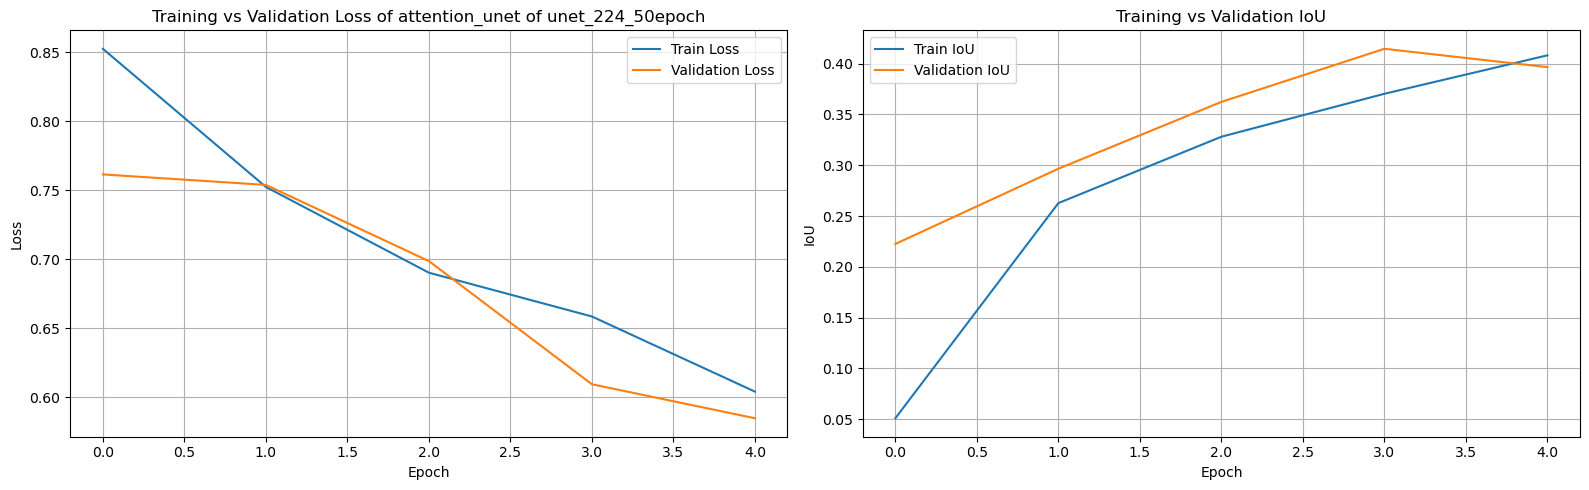

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = 'models/unet_test/log.csv'
df = pd.read_csv(log_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))  


axes[0].plot(df['epoch'], df['loss'], label='Train Loss')
axes[0].plot(df['epoch'], df['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss of attention_unet of unet_224_50epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df['epoch'], df['iou'], label='Train IoU')
axes[1].plot(df['epoch'], df['val_iou'], label='Validation IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training vs Validation IoU')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## ------------------------------------------
# 2 hybrid segmentation architecture
I independently designed and implemented these two segmentation architectures.

## 1/2 hybrid_Attention_transUnet
### 1.1 Edit ResNetV2
Part of the code in the following chunk was adapted from `from Beckschen_TransUNet.networks.vit_seg_modeling_resnet_skip import ResNetV2`.

In [13]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from os.path import join as pjoin
from collections import OrderedDict



def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)

class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block."""

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel")], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel")], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel")], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale")])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias")])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale")])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias")])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale")])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias")])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel")], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale")])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias")])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

In [14]:
class ResNetV2(nn.Module):                              
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        
        x = self.root(x)
        features.append(x)  # feature 0 (64x112x112)
    
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)  # -> 56x56  # 本来 padding=1
    
        for i in range(len(self.body)-1):  # block1, block2
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, f"x {x.size()} should {right_size}"
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
    
        # 🔧 block3 最后特征也加入 features（最深层）
        x = self.body[-1](x)
        features.append(x)  # ✅ 添加这一行！
    
        return x, features[::-1]  # 从深到浅排列（[512, 28, 28] -> [64, 112, 112]）

### 1.2 Define unetConv2

In [15]:
from ozan_oktay_Attention_UNet.models.networks_other import init_weights 

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

### 1.3 Modify unetUp

In [16]:
class unetUp(nn.Module):
    def __init__(self, up_in_channels, cat_in_channels, out_channels, is_deconv):
        super(unetUp, self).__init__()

        if is_deconv:
            self.up = nn.ConvTranspose2d(up_in_channels, up_in_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        self.conv = unetConv2(cat_in_channels, out_channels, False)

        # initialise
        for m in self.children():
            if isinstance(m, unetConv2): continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        
        diffY = outputs2.size()[2] - inputs1.size()[2]     
        diffX = outputs2.size()[3] - inputs1.size()[3]
        
        outputs1 = F.pad(inputs1, [diffX // 2, diffX - diffX // 2,
                                   diffY // 2, diffY - diffY // 2])
        
        return self.conv(torch.cat([outputs1, outputs2], dim=1))


### 1.4 class HybridAttentionUNet 🔥
🔥 this is Critical components ！

In [17]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from ozan_oktay_Attention_UNet.models.layers.nonlocal_layer import NONLocalBlock2D


class HybridAttentionUNet(nn.Module):
    def __init__(self, n_classes=1, is_deconv=True, feature_scale=4, nonlocal_mode='embedded_gaussian', nonlocal_sf=4):
        super(HybridAttentionUNet, self).__init__()

        self.is_deconv = is_deconv
        self.feature_scale = feature_scale

        # Use ResNetV2 as the encoder (replacing the original conv1~center)
        self.resnet_encoder = ResNetV2(block_units=[3, 4, 9], width_factor=1)

        # Get the number of feature channels from the encoder output, as known from TransUNet, they are: 
        self.enc_channels = [64, 256, 512, 1024]  # order of features returned from ResNetV2 body

        # Build non-local attention
        self.nonlocal1 = NONLocalBlock2D(in_channels=self.enc_channels[0], inter_channels=self.enc_channels[0] // 4,
                                         sub_sample_factor=nonlocal_sf, mode=nonlocal_mode)
        self.nonlocal2 = NONLocalBlock2D(in_channels=self.enc_channels[1], inter_channels=self.enc_channels[1] // 4,
                                         sub_sample_factor=nonlocal_sf, mode=nonlocal_mode)


        self.up_concat4 = unetUp(up_in_channels=1024, cat_in_channels=2048, out_channels=512, is_deconv=is_deconv) 
        self.up_concat3 = unetUp(512, 1024, 256, is_deconv)
        self.up_concat2 = unetUp(256, 512, 128, is_deconv)
        self.up_concat1 = unetUp(128, 192, 64, is_deconv)

        
        # After reducing output channels, connect to the classification layer
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

        
        # Initialize the weights of the final conv
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, inputs):
        x, features = self.resnet_encoder(inputs)
    
        # Now features[0] is the deepest layer (512x28x28), 
        # while features[3] is the shallowest layer (64x112x112)
        conv4 = features[0]
        conv3 = features[1]
        conv2 = features[2]
        conv1 = features[3]
    
        # Non-local attention
        conv1 = self.nonlocal1(conv1)
        conv2 = self.nonlocal2(conv2)
    
        center = x  # alternatively, use conv4

        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)
    
        final = self.final(up1)
        
        return final


    @staticmethod
    def apply_argmax_softmax(pred):
        return F.softmax(pred, dim=1)

### 1.5 train model
now we begin our pipeline  

In [18]:
import argparse
import os
from collections import OrderedDict
from glob import glob
import pandas as pd

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import yaml
import albumentations as A
from albumentations.core.composition import Compose, OneOf  # version of albumentaation 1.3.1
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
from albumentations import RandomRotate90,Resize
import numpy as np
import random

import sys
sys.path.append('./src')
import archs
import losses
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter, str2bool


def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name: (default: arch)')
    parser.add_argument('--epochs', default=50, type=int, metavar='N',   
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=4, type=int,
                        metavar='N', help='mini-batch size (default: 16)')
    
    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='Axial')   
    parser.add_argument('--deep_supervision', default=False, type=str2bool)
    parser.add_argument('--input_channels', default=3, type=int,           
                        help='input channels')
    parser.add_argument('--num_classes', default=1, type=int,              
                        help='number of classes')
    parser.add_argument('--input_w', default=384, type=int,                
                        help='image width')
    parser.add_argument('--input_h', default=384, type=int,
                        help='image height')
    
    # loss
    parser.add_argument('--loss', default='BCEDiceLoss',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: BCEDiceLoss)')
    
    # dataset
    parser.add_argument('--dataset', default='ICOS',
                        help='dataset name')
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    parser.add_argument('--mask_ext', default='.jpg',
                        help='mask file extension')

    # optimizer
    parser.add_argument('--optimizer', default='Adam',
                        choices=['Adam', 'SGD'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD']) +
                        ' (default: Adam)')
    parser.add_argument('--lr', '--learning_rate', default=1e-4, type=float,  
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')

    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-5, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.1, type=float)
    parser.add_argument('--patience', default=2, type=int)
    parser.add_argument('--milestones', default='1,2', type=str)
    parser.add_argument('--gamma', default=2/3, type=float)
    parser.add_argument('--early_stopping', default=-1, type=int,
                        metavar='N', help='early stopping (default: -1)')
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', )

    parser.add_argument('--num_workers', default=4, type=int)

    config = parser.parse_args()

    return config


# args = parser.parse_args()
def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target in train_loader:     
        input = input.cuda()
        target = target.cuda()
        target = target.unsqueeze(1)

        # compute output
        if config['deep_supervision']:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou,dice = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou,dice = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target in val_loader:     
            input = input.cuda()
            target = target.cuda()
            target = target.unsqueeze(1)

            # compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou,dice = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou,dice = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))
            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, mask):
        # mask = mask.unsqueeze(dim=1)
        weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
        wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
        wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

        pred = torch.sigmoid(pred)
        smooth = 1
        size = pred.size(0)
        pred_flat = pred.view(size, -1)
        mask_flat = mask.view(size, -1)
        intersection = pred_flat * mask_flat
        dice_score = (2 * intersection.sum(1) + smooth) / (pred_flat.sum(1) + mask_flat.sum(1) + smooth)
        dice_loss = 1 - dice_score.sum() / size

        return (wbce + 0.6*dice_loss).mean()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def main():
    
    config = {
    'name': 'atten_transUnet_test',
    'epochs': 5, # I recommend 100 epochs for fully demonstrating the potential of transUnet. Here I use 5 epochs to test whether the code runs successfully. 
    'batch_size': 16,                
    'arch': 'Axial',
    'deep_supervision': False,
    'input_channels': 3,
    'num_classes': 1,
    'input_w': 384,           
    'input_h': 384,           
    'loss': 'BCEDiceLoss',
    'dataset': 'ICOS',
    'img_ext': '.jpg',
    'mask_ext': '.jpg',
    'optimizer': 'Adam',
    
    'lr': 1e-4,                    # I recommend 1e-4 rather than 1e-3
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'nesterov': False,
    'scheduler': 'CosineAnnealingLR',  
    'min_lr': 1e-6,
    'factor': 0.1,
    'patience': 2,
    'milestones': '1,2',
    'gamma': 2/3,
    'early_stopping': -1, 
    'num_workers': 12     
}
    set_seed(42)
    
    if config['name'] is None:
        if config['deep_supervision']:
            config['name'] = '%s_%s_wDS' % (config['dataset'], config['arch'])
        else:
            config['name'] = '%s_%s_woDS' % (config['dataset'], config['arch'])
    
    os.makedirs('models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    with open('models/%s/config.yml' % config['name'], 'w') as f:
        yaml.dump(config, f)

    # define loss function (criterion)
    if config['loss'] == 'BCEDiceLoss':
        criterion = BCEDiceLoss().cuda() #nn.BCEWithLogitsLoss().cuda()
    else:
        criterion = losses.__dict__[config['loss']]().cuda()
    cudnn.benchmark = True

    model = HybridAttentionUNet(n_classes=config['num_classes'])    
    model = model.cuda()

    params = filter(lambda p: p.requires_grad, model.parameters())

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print ("\nTrainable parameters", pytorch_total_params)
    
    # print(params)
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(
            params, lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
                              nesterov=config['nesterov'], weight_decay=config['weight_decay'])
    else:
        raise NotImplementedError

    if config['scheduler'] == 'CosineAnnealingLR':                     
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
    
    elif config['scheduler'] == 'CosineAnnealingWarmRestarts':         
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(          
            optimizer, T_0=50, T_mult=1, eta_min=config['min_lr'])
    
    elif config['scheduler'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=config['factor'], patience=config['patience'],
            verbose=1, min_lr=config['min_lr'])
        
    elif config['scheduler'] == 'MultiStepLR':
        scheduler = lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(e) for e in config['milestones'].split(',')],
            gamma=config['gamma'])
    elif config['scheduler'] == 'ConstantLR':
        scheduler = None
    else:
        raise NotImplementedError
    
    # Data loading code
    train_img_ids = glob('dataset_TN3K/training_image/*')
    train_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in train_img_ids]

    val_img_ids = glob('dataset_TN3K/validation_image/*')
    val_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in val_img_ids]
    

    train_transform = Compose([
        RandomRotate90(),
        A.HorizontalFlip(),         
        A.VerticalFlip(),           
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=45, p=0.75),
        A.Transpose(),
        Resize(config['input_h'], config['input_w']), # we did here
        A.Normalize(),
    ])

    val_transform = Compose([
        Resize(config['input_h'], config['input_w']),
        A.Normalize(),
    ])

    train_dataset = Dataset(
        img_ids=train_img_ids,
        img_dir='dataset_TN3K/training_image',
        mask_dir='dataset_TN3K/training_mask',
        
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=train_transform)
    
    val_dataset = Dataset(
        img_ids=val_img_ids,
        img_dir=os.path.join('dataset_TN3K/validation_image'),
        mask_dir=os.path.join('dataset_TN3K/validation_mask'),
        
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=val_transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        drop_last=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False)
    log = OrderedDict([
        ('epoch', []),
        ('lr', []),
        ('loss', []),
        ('iou', []),
        ('val_loss', []),
        ('val_iou', []),
        ('val_dice', []),
    ])

    best_iou = 0
    trigger = 0
    for epoch in range(config['epochs']):
        print('Epoch [%d/%d]' % (epoch, config['epochs']))

        # train for one epoch
        train_log = train(config, train_loader, model, criterion, optimizer)
       
        # evaluate on validation set
        val_log = validate(config, val_loader, model, criterion)

        if config['scheduler'] == 'CosineAnnealingLR':            
            scheduler.step()

        elif config['scheduler'] == 'CosineAnnealingWarmRestarts': 
            scheduler.step(epoch)
        
        elif config['scheduler'] == 'ReduceLROnPlateau':
            scheduler.step(val_log['loss'])


        print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

        log['epoch'].append(epoch)
        log['lr'].append(optimizer.param_groups[0]['lr'])       
        print(f"Current LR: {optimizer.param_groups[0]['lr']}") 

        log['loss'].append(train_log['loss'])
        log['iou'].append(train_log['iou'])
        log['val_loss'].append(val_log['loss'])
        log['val_iou'].append(val_log['iou'])
        log['val_dice'].append(val_log['dice'])

        
        pd.DataFrame(log).to_csv('models/%s/log.csv' %
                                 config['name'], index=False)

        trigger += 1

        if val_log['iou'] > best_iou:
            torch.save(model.state_dict(), 'models/%s/model.pth' %
                       config['name'])
            best_iou = val_log['iou']
            print("=> saved best model")
            trigger = 0

        # early stopping
        if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
            print("=> early stopping")
            break

        torch.cuda.empty_cache()


if __name__ == '__main__':
    main()
    

Validating and Predicting:   0%|          | 0/614 [13:28:55<?, ?it/s]


--------------------
name: atten_transUnet_test
epochs: 5
batch_size: 16
arch: Axial
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 384
input_h: 384
loss: BCEDiceLoss
dataset: ICOS
img_ext: .jpg
mask_ext: .jpg
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
scheduler: CosineAnnealingLR
min_lr: 1e-06
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
num_workers: 12
--------------------


/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/layers/nonlocal_layer.py:51: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(self.W[1].weight, 0)
/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/layers/nonlocal_layer.py:52: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(self.W[1].bias, 0)
/data/home/ha24521/.conda/envs/Practical_5/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Trainable parameters 49882161
Epoch [0/5]


100%|██████████| 36/36 [00:06<00:00,  5.21it/s, loss=0.887, iou=0.208, dice=0.344]


loss 1.3557 - iou 0.1508 - val_loss 0.8868 - val_iou 0.2083
Current LR: 9.05463412215599e-05
=> saved best model
Epoch [1/5]


100%|██████████| 36/36 [00:06<00:00,  5.49it/s, loss=0.767, iou=0.245, dice=0.393]


loss 0.8187 - iou 0.2008 - val_loss 0.7668 - val_iou 0.2453
Current LR: 6.57963412215599e-05
=> saved best model
Epoch [2/5]


100%|██████████| 36/36 [00:06<00:00,  5.46it/s, loss=0.707, iou=0.324, dice=0.487]


loss 0.7389 - iou 0.2728 - val_loss 0.7068 - val_iou 0.3237
Current LR: 3.52036587784401e-05
=> saved best model
Epoch [3/5]


100%|██████████| 36/36 [00:06<00:00,  5.50it/s, loss=0.645, iou=0.387, dice=0.555]


loss 0.6979 - iou 0.3293 - val_loss 0.6452 - val_iou 0.3871
Current LR: 1.0453658778440105e-05
=> saved best model
Epoch [4/5]


100%|██████████| 36/36 [00:06<00:00,  5.47it/s, loss=0.628, iou=0.417, dice=0.585]


loss 0.6517 - iou 0.3791 - val_loss 0.6280 - val_iou 0.4171
Current LR: 1e-06
=> saved best model


### 1.6 calculate IoU and Dice

In [19]:
import argparse
import os
from collections import OrderedDict
from glob import glob
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

import yaml
from tqdm import tqdm
import albumentations as A
from albumentations.core.composition import Compose
from PIL import Image
import numpy as np
import random

import sys
sys.path.append('./src')
import archs 
import losses
from metrics import iou_score
from dataset_alt import Dataset 


def validate_and_predict(config, test_loader, model, criterion, output_dir):
    avg_meters = {'loss': AverageMeter(), # 
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        pbar = tqdm(total=len(test_loader), desc="Validating and Predicting")
        for i, (input, target, metadata) in enumerate(test_loader):
            img_id = metadata['img_id'][0] 

            input = input.cuda()
            target = target.cuda()
            target_original_shape = target.shape[1:] # Get H, W of original mask
            target = target.unsqueeze(1) # Add channel dimension

            # Print original image and mask sizes
            print(f"\nProcessing image ID: {img_id}") 
            print(f"Input ultrasound image size (H, W): {input.shape[2:]}")
            print(f"Ground truth mask size (H, W): {target_original_shape}")

            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                output = outputs[-1] # Use the last output for final prediction
            else:
                output = model(input)
                loss = criterion(output, target)

            output = F.interpolate(output, size=target_original_shape, mode="bilinear", align_corners=False)

            iou, dice = iou_score(output, target) 

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)

            # Save prediction mask
            pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0] # Take first image in batch, first channel
            pred_mask[pred_mask>=0.5]=1   
            pred_mask[pred_mask<0.5]=0
            
            pred_mask = (pred_mask * 255).astype(np.uint8)
            predicted_image = Image.fromarray(pred_mask)
            predicted_image.save(os.path.join(output_dir, f"{img_id}_pred.jpg"))

        pbar.close()
    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

def main():
    set_seed(42)
    
    # Load the configuration used for training
    config_path = 'models/atten_transUnet_test/config.yml' 
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    print('-' * 20)
    print("Loaded training configuration:")
    for key in config:
        print(f'{key}: {config[key]}')
    print('-' * 20)

    # Define loss function (criterion) - must match training
    if config['loss'] == 'BCEDiceLoss':
        criterion = BCEDiceLoss().cuda()
    else:
        # Assuming other losses are defined in losses.py
        criterion = losses.__dict__[config['loss']]().cuda()
    cudnn.benchmark = True

    model = HybridAttentionUNet(n_classes=config['num_classes'])  
    model = model.cuda()

    model_path = 'models/atten_transUnet_test/model.pth'  
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Successfully loaded model weights from {model_path}")
    else:
        print(f"Error: Model weights not found at {model_path}. Please ensure the training was successful.")
        return

    # Data loading code for test set
    test_img_dir = 'dataset_TN3K/test-image'
    test_mask_dir = 'dataset_TN3K/test-mask'

    test_img_ids = glob(os.path.join(test_img_dir, f'*{config["img_ext"]}'))
    test_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in test_img_ids]

    if not test_img_ids:
        print(f"No test images found in {test_img_dir}. Please check the path and extension.")
        return

    test_transform = Compose([
        A.Resize(config['input_h'], config['input_w']), # Resize for model input
        A.Normalize(),
    ])

    test_dataset = Dataset(
        img_ids=test_img_ids,
        img_dir=test_img_dir,
        mask_dir=test_mask_dir,
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=test_transform
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1, 
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False
    )

    output_prediction_dir = 'models/atten_transUnet_test/predictions' 
    print(f"\nStarting evaluation and prediction saving to: {output_prediction_dir}")
    val_log = validate_and_predict(config, test_loader, model, criterion, output_prediction_dir)

    print(f"\n--- Evaluation Results ---")
    print(f"Test Loss: {val_log['loss']:.4f}")
    print(f"Test IoU: {val_log['iou']:.4f}")
    print(f"Test Dice: {val_log['dice']:.4f}")
    print(f"Predicted masks saved to {output_prediction_dir}")

if __name__ == '__main__':
    main()

--------------------
Loaded training configuration:
arch: Axial
batch_size: 16
dataset: ICOS
deep_supervision: False
early_stopping: -1
epochs: 5
factor: 0.1
gamma: 0.6666666666666666
img_ext: .jpg
input_channels: 3
input_h: 384
input_w: 384
loss: BCEDiceLoss
lr: 0.0001
mask_ext: .jpg
milestones: 1,2
min_lr: 1e-06
momentum: 0.9
name: atten_transUnet_test
nesterov: False
num_classes: 1
num_workers: 12
optimizer: Adam
patience: 2
scheduler: CosineAnnealingLR
weight_decay: 0.0001
--------------------
Successfully loaded model weights from models/atten_transUnet_test/model.pth

Starting evaluation and prediction saving to: models/atten_transUnet_test/predictions


Validating and Predicting:   0%|          | 0/614 [00:00<?, ?it/s]


Processing image ID: 0183
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:   1%|▏         | 8/614 [00:03<02:25,  4.15it/s, loss=0.846, iou=0.217, dice=0.316] 


Processing image ID: 0586
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0350
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0073
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0476
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0240
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0366
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0130
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:   2%|▏         | 15/614 [00:03<01:16,  7.80it/s, loss=0.772, iou=0.231, dice=0.343]


Processing image ID: 0227
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0533
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0020
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0117
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0423
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0007
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0184
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:   4%|▍         | 24/614 [00:03<00:35, 16.47it/s, loss=0.709, iou=0.289, dice=0.409]


Processing image ID: 0351
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0074
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0477
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0241
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0367
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0131
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0228
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:   6%|▌         | 34/614 [00:03<00:22, 25.59it/s, loss=0.66, iou=0.307, dice=0.424] 


Processing image ID: 0118
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0424
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0008
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0185
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0491
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0588
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0352
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:   7%|▋         | 43/614 [00:03<00:17, 33.17it/s, loss=0.693, iou=0.3, dice=0.415]  


Processing image ID: 0242
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0368
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0132
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0229
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0535
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0119
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0009
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:   9%|▊         | 53/614 [00:04<00:14, 38.30it/s, loss=0.688, iou=0.291, dice=0.408]


Processing image ID: 0589
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0353
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0076
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0479
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0243
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0410
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0369
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  10%|▉         | 61/614 [00:04<00:13, 39.77it/s, loss=0.7, iou=0.275, dice=0.388]  


Processing image ID: 0300
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0090
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0187
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0493
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0354
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0077
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0244
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  11%|█▏        | 70/614 [00:04<00:12, 42.02it/s, loss=0.687, iou=0.275, dice=0.392]


Processing image ID: 0537
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0301
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0091
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0188
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0494
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0355
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0078
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  12%|█▏        | 76/614 [00:04<00:12, 42.50it/s, loss=0.678, iou=0.291, dice=0.41] 


Processing image ID: 0135
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0538
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0302
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0299
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0092
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0189
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  13%|█▎        | 79/614 [00:05<00:17, 30.56it/s, loss=0.677, iou=0.294, dice=0.414]


Processing image ID: 0495
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0356
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0079
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0246
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  14%|█▍        | 88/614 [00:05<00:17, 29.73it/s, loss=0.664, iou=0.302, dice=0.424]


Processing image ID: 0010
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0413
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0136
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0539
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0303
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0480
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0370
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  16%|█▌        | 97/614 [00:05<00:14, 35.59it/s, loss=0.658, iou=0.312, dice=0.435]


Processing image ID: 0260
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0357
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0247
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0011
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0414
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0137
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0304
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  16%|█▌        | 98/614 [00:05<00:14, 35.59it/s, loss=0.654, iou=0.316, dice=0.44] 


Processing image ID: 0481
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0371
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0094
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  16%|█▋        | 101/614 [00:05<00:23, 21.88it/s, loss=0.65, iou=0.319, dice=0.444]


Processing image ID: 0497
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0261
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  17%|█▋        | 103/614 [00:06<00:23, 21.88it/s, loss=0.648, iou=0.32, dice=0.445] 


Processing image ID: 0358
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0248
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  17%|█▋        | 106/614 [00:06<00:35, 14.27it/s, loss=0.648, iou=0.32, dice=0.447]


Processing image ID: 0012
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0415
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0138
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  18%|█▊        | 109/614 [00:06<00:35, 14.20it/s, loss=0.644, iou=0.322, dice=0.449]


Processing image ID: 0305
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0482
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0372
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  19%|█▉        | 117/614 [00:07<00:29, 16.58it/s, loss=0.64, iou=0.321, dice=0.447] 


Processing image ID: 0095
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0498
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0262
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0359
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0123
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0526
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0249
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  21%|██        | 126/614 [00:07<00:19, 25.54it/s, loss=0.635, iou=0.326, dice=0.453]


Processing image ID: 0139
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0306
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0080
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0483
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0373
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0540
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0096
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  22%|██▏       | 136/614 [00:07<00:14, 32.67it/s, loss=0.637, iou=0.321, dice=0.447]


Processing image ID: 0124
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0430
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0527
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0014
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0320
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0417
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0307
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  24%|██▎       | 145/614 [00:07<00:16, 28.97it/s, loss=0.634, iou=0.321, dice=0.447]


Processing image ID: 0374
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0541
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0097
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0264
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0125
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0431
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0528
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  25%|██▌       | 154/614 [00:08<00:14, 32.43it/s, loss=0.629, iou=0.332, dice=0.46] 


Processing image ID: 0418
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0308
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0082
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0485
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0375
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0542
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0265
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  26%|██▋       | 162/614 [00:08<00:12, 37.64it/s, loss=0.629, iou=0.333, dice=0.461]


Processing image ID: 0529
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0016
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0322
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0419
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0309
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0083
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0486
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  28%|██▊       | 171/614 [00:08<00:10, 40.54it/s, loss=0.629, iou=0.329, dice=0.455]


Processing image ID: 0140
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0543
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0266
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0030
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0127
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0433
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0600
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  29%|██▉       | 181/614 [00:08<00:10, 42.13it/s, loss=0.624, iou=0.335, dice=0.461]


Processing image ID: 0084
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0390
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0487
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0251
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0377
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0141
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0544
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  31%|███       | 190/614 [00:08<00:09, 43.31it/s, loss=0.625, iou=0.332, dice=0.457]


Processing image ID: 0128
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0434
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0601
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0018
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0085
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0391
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0488
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  32%|███▏      | 199/614 [00:09<00:09, 43.57it/s, loss=0.62, iou=0.334, dice=0.46]  


Processing image ID: 0142
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0545
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0268
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0032
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0129
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0435
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0602
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  34%|███▍      | 208/614 [00:09<00:09, 43.71it/s, loss=0.619, iou=0.332, dice=0.458]


Processing image ID: 0392
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0489
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0253
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0379
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0143
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0546
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0310
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  35%|███▌      | 217/614 [00:09<00:08, 44.12it/s, loss=0.614, iou=0.336, dice=0.462]


Processing image ID: 0436
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0200
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0603
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0087
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0393
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0254
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0560
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  37%|███▋      | 226/614 [00:09<00:08, 44.36it/s, loss=0.612, iou=0.336, dice=0.463]


Processing image ID: 0311
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0034
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0437
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0201
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0604
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0088
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0394
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  38%|███▊      | 235/614 [00:09<00:08, 44.65it/s, loss=0.608, iou=0.337, dice=0.465]


Processing image ID: 0145
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0548
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0312
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0035
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0438
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0202
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0605
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  40%|███▉      | 245/614 [00:10<00:08, 43.43it/s, loss=0.607, iou=0.335, dice=0.462]


Processing image ID: 0256
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0562
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0146
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0549
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0313
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0036
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0439
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  41%|████      | 253/614 [00:10<00:08, 43.73it/s, loss=0.609, iou=0.335, dice=0.462]


Processing image ID: 0380
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0270
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0396
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0160
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0257
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0563
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0147
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  43%|████▎     | 263/614 [00:10<00:08, 42.31it/s, loss=0.611, iou=0.329, dice=0.455]


Processing image ID: 0204
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0607
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0381
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0271
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0397
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0161
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0258
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  44%|████▍     | 272/614 [00:10<00:07, 43.42it/s, loss=0.612, iou=0.327, dice=0.453]


Processing image ID: 0425
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0148
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0315
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0038
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0205
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0608
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0382
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  46%|████▌     | 281/614 [00:10<00:07, 43.77it/s, loss=0.613, iou=0.323, dice=0.448]


Processing image ID: 0162
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0259
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0565
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0023
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0426
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0149
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0316
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  47%|████▋     | 290/614 [00:11<00:07, 43.85it/s, loss=0.613, iou=0.323, dice=0.448]


Processing image ID: 0609
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0383
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0550
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0273
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0440
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0399
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0163
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  49%|████▉     | 300/614 [00:11<00:07, 44.17it/s, loss=0.609, iou=0.326, dice=0.452]


Processing image ID: 0330
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0427
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0220
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0317
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0207
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0384
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0551
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  50%|█████     | 307/614 [00:11<00:07, 43.67it/s, loss=0.608, iou=0.327, dice=0.453]


Processing image ID: 0164
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0567
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0025
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0331
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0428
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0221
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0318
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  51%|█████▏    | 316/614 [00:11<00:06, 42.94it/s, loss=0.607, iou=0.328, dice=0.454]


Processing image ID: 0552
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0275
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0442
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0165
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0568
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0026
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0332
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  53%|█████▎    | 326/614 [00:12<00:06, 42.94it/s, loss=0.608, iou=0.329, dice=0.454]


Processing image ID: 0319
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0209
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0386
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0150
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0553
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0276
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0040
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  55%|█████▍    | 335/614 [00:12<00:06, 43.48it/s, loss=0.608, iou=0.328, dice=0.453]


Processing image ID: 0166
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0569
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0027
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0333
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0500
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0223
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0290
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  56%|█████▌    | 345/614 [00:12<00:06, 43.93it/s, loss=0.609, iou=0.328, dice=0.454]


Processing image ID: 0554
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0277
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0041
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0444
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0611
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0167
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0028
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  57%|█████▋    | 352/614 [00:12<00:06, 43.06it/s, loss=0.606, iou=0.331, dice=0.456]


Processing image ID: 0291
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0388
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0152
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0555
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0278
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0042
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0445
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  59%|█████▉    | 362/614 [00:12<00:05, 43.74it/s, loss=0.605, iou=0.333, dice=0.457]


Processing image ID: 0029
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0335
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0502
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0292
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0389
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0153
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0556
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  60%|██████    | 371/614 [00:13<00:05, 44.14it/s, loss=0.605, iou=0.336, dice=0.46] 


Processing image ID: 0446
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0210
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0613
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0169
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0336
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0100
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0503
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  62%|██████▏   | 380/614 [00:13<00:05, 44.36it/s, loss=0.606, iou=0.332, dice=0.456]


Processing image ID: 0154
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0460
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0557
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0044
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0447
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0211
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0337
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  64%|██████▎   | 390/614 [00:13<00:05, 44.35it/s, loss=0.604, iou=0.335, dice=0.459]


Processing image ID: 0098
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0571
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0294
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0155
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0461
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0558
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0045
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  65%|██████▍   | 398/614 [00:13<00:04, 44.12it/s, loss=0.603, iou=0.337, dice=0.461]


Processing image ID: 0338
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0102
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0505
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0099
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0572
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0295
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0156
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  66%|██████▌   | 406/614 [00:13<00:04, 43.80it/s, loss=0.599, iou=0.342, dice=0.466]


Processing image ID: 0046
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0449
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0213
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0339
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0103
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0506
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0280
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  68%|██████▊   | 416/614 [00:14<00:04, 43.90it/s, loss=0.597, iou=0.343, dice=0.467]


Processing image ID: 0296
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0060
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0157
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0463
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0324
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0047
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0214
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  69%|██████▉   | 425/614 [00:14<00:04, 43.22it/s, loss=0.598, iou=0.341, dice=0.466]


Processing image ID: 0507
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0281
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0171
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0574
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0297
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0061
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0158
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  71%|███████   | 435/614 [00:14<00:04, 43.78it/s, loss=0.598, iou=0.342, dice=0.467]


Processing image ID: 0048
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0215
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0521
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0105
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0508
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0282
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0172
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  72%|███████▏  | 443/614 [00:14<00:03, 44.06it/s, loss=0.598, iou=0.343, dice=0.468]


Processing image ID: 0062
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0159
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0465
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0326
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0049
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0216
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0522
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  73%|███████▎  | 451/614 [00:14<00:03, 41.90it/s, loss=0.596, iou=0.342, dice=0.467]


Processing image ID: 0283
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0450
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0173
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0576
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0340
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0063
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0466
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  75%|███████▍  | 460/614 [00:15<00:03, 41.08it/s, loss=0.597, iou=0.34, dice=0.465] 


Processing image ID: 0120
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0217
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0523
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0107
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0284
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0590
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0451
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  77%|███████▋  | 470/614 [00:15<00:03, 41.50it/s, loss=0.597, iou=0.34, dice=0.465] 


Processing image ID: 0341
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0064
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0467
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0231
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0328
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0121
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0218
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  78%|███████▊  | 478/614 [00:15<00:03, 42.07it/s, loss=0.597, iou=0.34, dice=0.466]


Processing image ID: 0285
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0591
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0452
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0175
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0578
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0342
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0065
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  79%|███████▉  | 487/614 [00:15<00:02, 42.36it/s, loss=0.596, iou=0.341, dice=0.467]


Processing image ID: 0329
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0122
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0219
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0525
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0109
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0286
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0592
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  81%|████████  | 496/614 [00:15<00:02, 42.69it/s, loss=0.596, iou=0.341, dice=0.466]


Processing image ID: 0176
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0579
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0343
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0510
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0066
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0469
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0233
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  82%|████████▏ | 505/614 [00:16<00:02, 42.92it/s, loss=0.597, iou=0.341, dice=0.466]


Processing image ID: 0287
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0593
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0051
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0454
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0177
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0344
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0511
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  84%|████████▍ | 515/614 [00:16<00:02, 43.51it/s, loss=0.601, iou=0.34, dice=0.466] 


Processing image ID: 0401
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0191
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0288
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0594
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0052
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0455
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0178
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  85%|████████▌ | 523/614 [00:16<00:02, 43.61it/s, loss=0.601, iou=0.339, dice=0.464]


Processing image ID: 0068
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0235
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0402
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0192
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0289
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0595
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0053
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  86%|████████▌ | 525/614 [00:16<00:02, 43.11it/s, loss=0.6, iou=0.339, dice=0.465]  


Processing image ID: 0346
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0110
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  86%|████████▋ | 530/614 [00:17<00:04, 19.52it/s, loss=0.602, iou=0.339, dice=0.464]


Processing image ID: 0513
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0069
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0236
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0000
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  87%|████████▋ | 534/614 [00:17<00:04, 18.64it/s, loss=0.602, iou=0.338, dice=0.463]


Processing image ID: 0403
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0580
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0470
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0193
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  88%|████████▊ | 538/614 [00:17<00:04, 17.32it/s, loss=0.601, iou=0.338, dice=0.464]


Processing image ID: 0596
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0054
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0360
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0457
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  88%|████████▊ | 541/614 [00:18<00:04, 16.31it/s, loss=0.601, iou=0.337, dice=0.463]


Processing image ID: 0347
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0111
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0514
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  89%|████████▊ | 544/614 [00:18<00:05, 13.43it/s, loss=0.601, iou=0.337, dice=0.463]


Processing image ID: 0237
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0001
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0404
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  89%|████████▉ | 546/614 [00:18<00:05, 13.02it/s, loss=0.601, iou=0.337, dice=0.463]


Processing image ID: 0581
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0471
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0194
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  90%|████████▉ | 550/614 [00:18<00:05, 12.21it/s, loss=0.6, iou=0.337, dice=0.463]  


Processing image ID: 0597
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0055
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0361
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  90%|████████▉ | 552/614 [00:19<00:05, 11.97it/s, loss=0.601, iou=0.337, dice=0.463]


Processing image ID: 0458
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0348
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0112
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  91%|█████████ | 560/614 [00:19<00:03, 16.08it/s, loss=0.601, iou=0.337, dice=0.464]


Processing image ID: 0515
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0238
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0002
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0405
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0582
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0472
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0195
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  92%|█████████▏| 566/614 [00:19<00:02, 21.81it/s, loss=0.602, iou=0.337, dice=0.464]


Processing image ID: 0056
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0362
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0459
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0349
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0113
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])


Validating and Predicting:  93%|█████████▎| 574/614 [00:19<00:01, 25.00it/s, loss=0.602, iou=0.338, dice=0.465]


Processing image ID: 0516
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0239
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0003
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0406
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0180
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0583
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0070
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  95%|█████████▍| 583/614 [00:20<00:00, 32.36it/s, loss=0.601, iou=0.341, dice=0.468]


Processing image ID: 0599
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0057
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0363
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0224
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0530
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0114
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0420
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  97%|█████████▋| 593/614 [00:20<00:00, 36.26it/s, loss=0.601, iou=0.341, dice=0.468]


Processing image ID: 0407
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0181
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0584
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0071
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0474
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0197
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0058
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting:  98%|█████████▊| 602/614 [00:20<00:00, 40.34it/s, loss=0.602, iou=0.34, dice=0.467] 


Processing image ID: 0531
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0115
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0421
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0518
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0005
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0408
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0182
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting: 100%|█████████▉| 612/614 [00:20<00:00, 42.76it/s, loss=0.602, iou=0.339, dice=0.466]


Processing image ID: 0198
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0059
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0365
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0226
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0532
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0116
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID: 0422
Input ultrasound image size (H, W): torch.Size([384, 384])
Ground truth mask size (H, W): torch.Size([384, 384])

Processing image ID

Validating and Predicting: 100%|██████████| 614/614 [00:20<00:00, 29.45it/s, loss=0.602, iou=0.34, dice=0.467] 


--- Evaluation Results ---
Test Loss: 0.6016
Test IoU: 0.3397
Test Dice: 0.4666
Predicted masks saved to models/atten_transUnet_test/predictions


--- Evaluation Results ---  
Test Loss: 0.6016  
Test IoU: 0.3397  
Test Dice: 0.4666  
Predicted masks saved to models/atten_transUnet_test/predictions

### 1.7 find the best model

In [20]:
import pandas as pd

log_path = 'models/atten_transUnet_test/log.csv'
df = pd.read_csv(log_path)

best_model_by_dice = df.loc[df['val_dice'].idxmax()]
best_model_by_iou = df.loc[df['val_iou'].idxmax()]

print("Best model by Dice coefficient of atten_transUnet_384_500epoch:")
print(best_model_by_dice)

print("\nBest model by IoU:")
print(best_model_by_iou)

Best model by Dice coefficient of atten_transUnet_384_500epoch:
epoch       4.000000
lr          0.000001
loss        0.651742
iou         0.379094
val_loss    0.627975
val_iou     0.417066
val_dice    0.584978
Name: 4, dtype: float64

Best model by IoU:
epoch       4.000000
lr          0.000001
loss        0.651742
iou         0.379094
val_loss    0.627975
val_iou     0.417066
val_dice    0.584978
Name: 4, dtype: float64


### 1.8 Plot curves
#### Loss and IoU curves

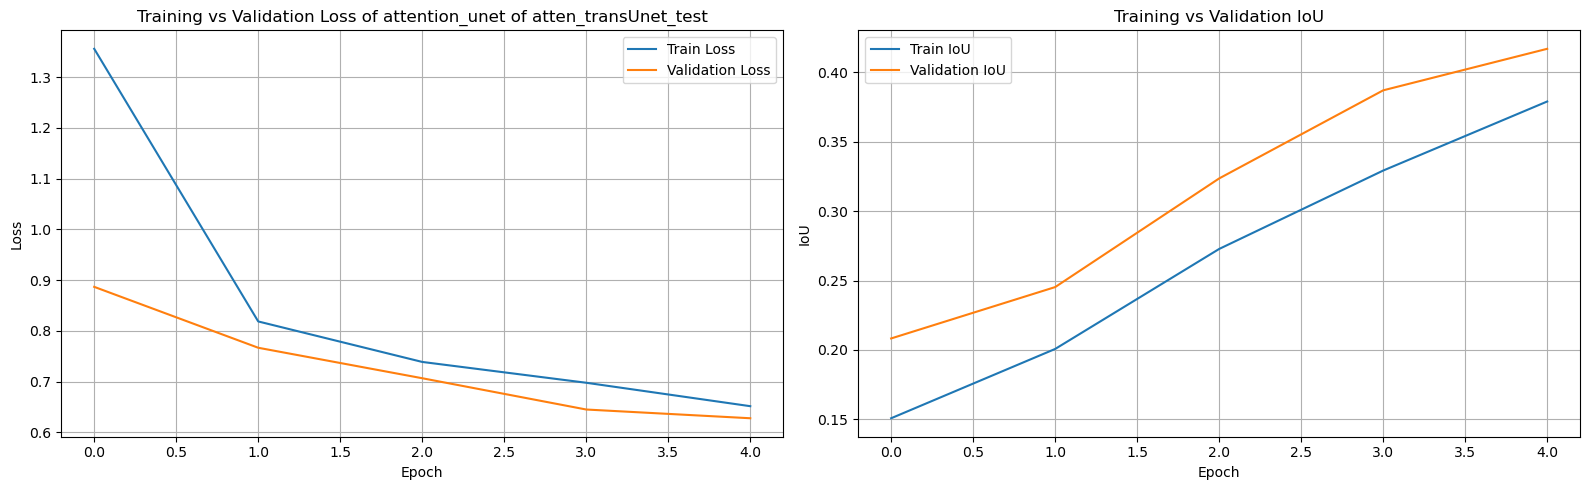

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = 'models/atten_transUnet_test/log.csv'
df = pd.read_csv(log_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))  

axes[0].plot(df['epoch'], df['loss'], label='Train Loss')
axes[0].plot(df['epoch'], df['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss of attention_unet of atten_transUnet_test')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df['epoch'], df['iou'], label='Train IoU')
axes[1].plot(df['epoch'], df['val_iou'], label='Validation IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training vs Validation IoU')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Learning rate curve

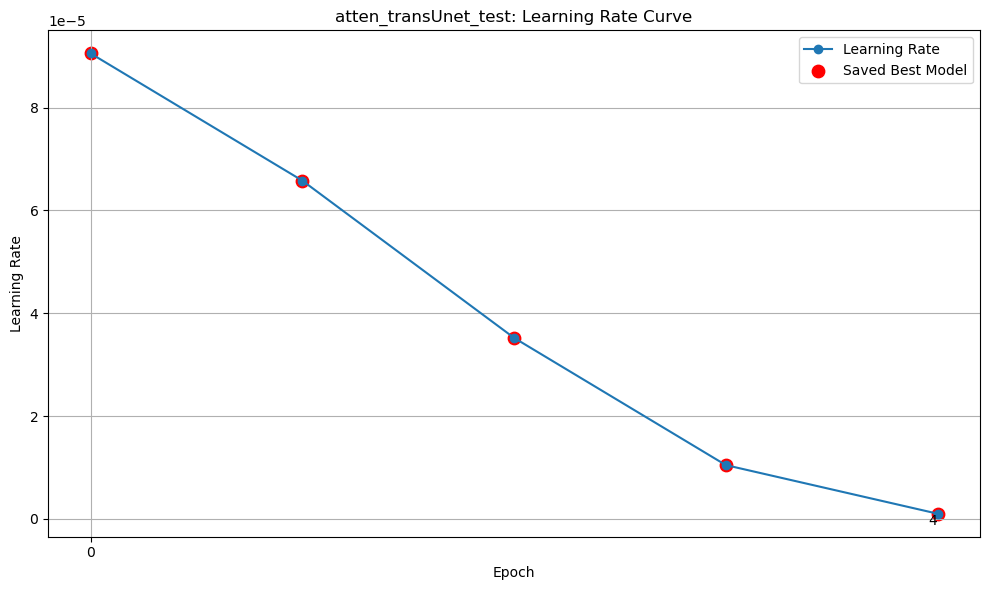

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv('models/atten_transUnet_test/log.csv')
epochs = log['epoch']
lrs = log['lr']
val_ious = log['val_iou']

best_epochs = []
best_so_far = -float('inf')
for i in range(len(val_ious)):
    if val_ious[i] > best_so_far:
        best_so_far = val_ious[i]
        best_epochs.append(i) 

plt.figure(figsize=(10, 6))
plt.plot(epochs, lrs, marker='o', label='Learning Rate')

max_epoch = epochs.max()
xticks = list(range(0, max_epoch + 1, 40))
plt.xticks(xticks)

plt.text(
    epochs.iloc[-1],
    lrs.iloc[-1] * 0.9,  
    f'{epochs.iloc[-1]}',
    color='black',
    fontsize=10,
    ha='right',
    va='top'
)

plt.scatter(epochs.iloc[best_epochs], lrs.iloc[best_epochs], 
            s=80, color='red', label='Saved Best Model')

# 图像美化
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('atten_transUnet_test: Learning Rate Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## ------------------------------------------
## 2/2 hybrid_Attention_transUnet_MobileViT
### 2.1 Edit ResNetV2
Part of the code in the following chunk was adapted from `from Beckschen_TransUNet.networks.vit_seg_modeling_resnet_skip import ResNetV2`

In [24]:
import math
from os.path import join as pjoin
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)

class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block."""

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel")], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel")], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel")], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale")])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias")])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale")])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias")])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale")])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias")])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel")], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale")])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias")])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

In [25]:
class ResNetV2(nn.Module):                              
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        
        x = self.root(x)
        features.append(x)  # feature 0 (64x112x112)
    
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)  # -> 56x56
    
        for i in range(len(self.body)-1):  # block1, block2
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, f"x {x.size()} should {right_size}"
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
    
        # Also add the final feature of block3 to features (deepest layer)
        x = self.body[-1](x)
        features.append(x)  # Add this line
    
        return x, features[::-1]  


### 2.2 Define unetConv2

In [26]:
from ozan_oktay_Attention_UNet.models.networks_other import init_weights 

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

### 2.3 Modify unetUp

In [27]:
class unetUp(nn.Module):
    def __init__(self, up_in_channels, cat_in_channels, out_channels, is_deconv):
        super(unetUp, self).__init__()

        if is_deconv:
            self.up = nn.ConvTranspose2d(up_in_channels, up_in_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        self.conv = unetConv2(cat_in_channels, out_channels, False)

        # initialise
        for m in self.children():
            if isinstance(m, unetConv2): continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], dim=1))


### 2.4 class HybridAttenTransMob 🔥

In [28]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from ozan_oktay_Attention_UNet.models.layers.nonlocal_layer import NONLocalBlock2D
from src.module import MobileVitBlock  


class HybridAttenTransMob(nn.Module):
    def __init__(self, n_classes=1, is_deconv=True, feature_scale=4, nonlocal_mode='embedded_gaussian', nonlocal_sf=4):
        super(HybridAttenTransMob, self).__init__()

        self.is_deconv = is_deconv
        self.feature_scale = feature_scale

        # Use ResNetV2 as the encoder (replacing the original conv1~center)
        self.resnet_encoder = ResNetV2(block_units=[3, 4, 9], width_factor=1)

        # Get the output channel dimensions from the encoder (as specified in TransUNet)
        self.enc_channels = [64, 256, 512, 1024]  # order of features returned by ResNetV2 body

        # Build non-local attention
        self.nonlocal1 = NONLocalBlock2D(in_channels=self.enc_channels[0], inter_channels=self.enc_channels[0] // 4,
                                         sub_sample_factor=nonlocal_sf, mode=nonlocal_mode)
        self.nonlocal2 = NONLocalBlock2D(in_channels=self.enc_channels[1], inter_channels=self.enc_channels[1] // 4,
                                         sub_sample_factor=nonlocal_sf, mode=nonlocal_mode)

        # Decoder part (from the Attention U-Net structure)
        self.up_concat4 = unetUp(up_in_channels=1024, cat_in_channels=2048, out_channels=512, is_deconv=is_deconv) # 第四版
        self.up_concat3 = unetUp(512, 1024, 256, is_deconv)
        self.up_concat2 = unetUp(256, 512, 128, is_deconv)
        self.up_concat1 = unetUp(128, 192, 64, is_deconv)

        # MobileViT block added to conv1 and conv2  
        self.mv_block1 = MobileVitBlock(
            in_channels=self.enc_channels[0],
            out_channels=self.enc_channels[0],      
            d_model=64,                             
            layers=1,
            mlp_dim=128
        )

        self.mv_block2 = MobileVitBlock(           
            in_channels=self.enc_channels[1],
            out_channels=self.enc_channels[1],
            d_model=96,
            layers=1,
            mlp_dim=192
        )
        
        # Reduce output channels before connecting to the classification layer
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)
        
        # Initialize the weights of the final conv layer
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, inputs):
        x, features = self.resnet_encoder(inputs)
    
        # Now features[0] is the deepest layer (512x28x28), and features[3] is the shallowest layer (64x112x112)
        conv4 = features[0]
        conv3 = features[1]
        conv2 = features[2]
        conv1 = features[3]
    
        # MobileViT block               
        conv1 = self.mv_block1(conv1)
        conv2 = self.mv_block2(conv2)
        
        # Non-local attention
        conv1 = self.nonlocal1(conv1)
        conv2 = self.nonlocal2(conv2)

        center = x  # alternatively, use conv4
        
        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)
    
        final = self.final(up1)
        
        return final


    @staticmethod
    def apply_argmax_softmax(pred):
        return F.softmax(pred, dim=1)


### 2.5 train model

In [29]:
import argparse
import os
from collections import OrderedDict
from glob import glob

import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import yaml
import albumentations as A
from albumentations.core.composition import Compose, OneOf  # version of albumentaation 1.3.1
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
from albumentations import RandomRotate90,Resize
import numpy as np
import random

import sys
sys.path.append('./src')
import archs
import losses
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter, str2bool


def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name: (default: arch)')
    parser.add_argument('--epochs', default=50, type=int, metavar='N',   
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=4, type=int,
                        metavar='N', help='mini-batch size (default: 16)')
    
    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='Axial')   
    parser.add_argument('--deep_supervision', default=False, type=str2bool)
    parser.add_argument('--input_channels', default=3, type=int,           
                        help='input channels')
    parser.add_argument('--num_classes', default=1, type=int,              
                        help='number of classes')
    parser.add_argument('--input_w', default=128, type=int,                
                        help='image width')
    parser.add_argument('--input_h', default=128, type=int,
                        help='image height')
    
    # loss
    parser.add_argument('--loss', default='BCEDiceLoss',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: BCEDiceLoss)')
    
    # dataset
    parser.add_argument('--dataset', default='ICOS',
                        help='dataset name')
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    parser.add_argument('--mask_ext', default='.jpg',
                        help='mask file extension')

    # optimizer
    parser.add_argument('--optimizer', default='Adam',
                        choices=['Adam', 'SGD'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD']) +
                        ' (default: Adam)')
    parser.add_argument('--lr', '--learning_rate', default=1e-4, type=float,  
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-4, type=float,           
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')

    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-6, type=float,           
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.5, type=float)            
    parser.add_argument('--patience', default=3, type=int)              
    parser.add_argument('--milestones', default='1,2', type=str)
    parser.add_argument('--gamma', default=2/3, type=float)
    parser.add_argument('--early_stopping', default=-1, type=int,
                        metavar='N', help='early stopping (default: -1)')
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', )
    # parser.add_argument('--cfg', type=str, required=True, metavar="FILE", help='path to config file', )

    parser.add_argument('--num_workers', default=4, type=int)

    config = parser.parse_args()

    return config


# args = parser.parse_args()
def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target in train_loader:     
        input = input.cuda()
        target = target.cuda()
        target = target.unsqueeze(1)

        # compute output
        if config['deep_supervision']:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou,dice = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou,dice = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target in val_loader:     
            input = input.cuda()
            target = target.cuda()
            target = target.unsqueeze(1)

            # compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou,dice = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou,dice = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))
            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, mask):
        weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
        wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
        wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

        pred = torch.sigmoid(pred)
        smooth = 1
        size = pred.size(0)
        pred_flat = pred.view(size, -1)
        mask_flat = mask.view(size, -1)
        intersection = pred_flat * mask_flat
        dice_score = (2 * intersection.sum(1) + smooth) / (pred_flat.sum(1) + mask_flat.sum(1) + smooth)
        dice_loss = 1 - dice_score.sum() / size

        return (wbce + 0.6*dice_loss).mean()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def main():
    
    config = {
    'name': 'atten_trans_Mob_test',
    'epochs': 5, # I recommend 200 epochs for fully demonstrating the potential of transUnet. Here I use 5 epochs to test whether the code runs successfully.
    'batch_size': 16,              
    'arch': 'Axial',
    'deep_supervision': False,
    'input_channels': 3,
    'num_classes': 1,
    'input_w': 224,
    'input_h': 224,
    'loss': 'BCEDiceLoss',
    'dataset': 'ICOS',
    'img_ext': '.jpg',
    'mask_ext': '.jpg',
    'optimizer': 'Adam',
    
    'lr': 5e-4,                       
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'nesterov': False,
    'scheduler': 'CosineAnnealingLR',
    'min_lr': 1e-6,                  
    'factor': 0.5,                   
    'patience': 3,                   
    'milestones': '1,2',
    'gamma': 2/3,
    'early_stopping': -1,          
    'num_workers': 16              
}
    set_seed(42)
    
    if config['name'] is None:
        if config['deep_supervision']:
            config['name'] = '%s_%s_wDS' % (config['dataset'], config['arch'])
        else:
            config['name'] = '%s_%s_woDS' % (config['dataset'], config['arch'])
    
    os.makedirs('models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    with open('models/%s/config.yml' % config['name'], 'w') as f:
        yaml.dump(config, f)

    # define loss function (criterion)
    if config['loss'] == 'BCEDiceLoss':
        criterion = BCEDiceLoss().cuda() #nn.BCEWithLogitsLoss().cuda()
    else:
        criterion = losses.__dict__[config['loss']]().cuda()
    cudnn.benchmark = True

    model = HybridAttenTransMob(n_classes=config['num_classes'])   
    model = model.cuda()

    params = filter(lambda p: p.requires_grad, model.parameters())

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print ("\nTrainable parameters", pytorch_total_params)
    
    # print(params)
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(
            params, lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
                              nesterov=config['nesterov'], weight_decay=config['weight_decay'])
    else:
        raise NotImplementedError

    if config['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
    elif config['scheduler'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=config['factor'], patience=config['patience'], min_lr=config['min_lr'])
    elif config['scheduler'] == 'MultiStepLR':
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(e) for e in config['milestones'].split(',')], gamma=config['gamma'])
    elif config['scheduler'] == 'ConstantLR':
        scheduler = None
    else:
        raise NotImplementedError

    # Data loading code
    train_img_ids = glob('dataset_TN3K/training_image/*')
    train_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in train_img_ids]

    val_img_ids = glob('dataset_TN3K/validation_image/*')
    val_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in val_img_ids]
    

    train_transform = Compose([
        RandomRotate90(),
        A.HorizontalFlip(),        
        A.VerticalFlip(),          
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=45, p=0.75),
        A.Transpose(),
        Resize(config['input_h'], config['input_w']), 
        A.Normalize(),
    ])

    val_transform = Compose([
        Resize(config['input_h'], config['input_w']),
        A.Normalize(),
    ])

    train_dataset = Dataset(
        img_ids=train_img_ids,
        img_dir='dataset_TN3K/training_image',
        mask_dir='dataset_TN3K/training_mask',
        
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=train_transform)
    
    val_dataset = Dataset(
        img_ids=val_img_ids,
        img_dir=os.path.join('dataset_TN3K/validation_image'),
        mask_dir=os.path.join('dataset_TN3K/validation_mask'),
        
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=val_transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        drop_last=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False)
    log = OrderedDict([
        ('epoch', []),
        ('lr', []),
        ('loss', []),
        ('iou', []),
        ('val_loss', []),
        ('val_iou', []),
        ('val_dice', []),
    ])

    best_iou = 0
    trigger = 0
    for epoch in range(config['epochs']):
        print('Epoch [%d/%d]' % (epoch, config['epochs']))

        # train for one epoch
        train_log = train(config, train_loader, model, criterion, optimizer)
        
        # evaluate on validation set
        val_log = validate(config, val_loader, model, criterion)

        if config['scheduler'] == 'CosineAnnealingLR':
            scheduler.step()
        elif config['scheduler'] == 'ReduceLROnPlateau':
            scheduler.step(val_log['loss'])

        print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

        log['epoch'].append(epoch)
        log['lr'].append(optimizer.param_groups[0]['lr'])       
        print(f"Current LR: {optimizer.param_groups[0]['lr']}") 

        log['loss'].append(train_log['loss'])
        log['iou'].append(train_log['iou'])
        log['val_loss'].append(val_log['loss'])
        log['val_iou'].append(val_log['iou'])
        log['val_dice'].append(val_log['dice'])

        pd.DataFrame(log).to_csv('models/%s/log.csv' % 
                                 config['name'], index=False)
        trigger += 1

        if val_log['iou'] > best_iou:
            torch.save(model.state_dict(), 'models/%s/model.pth' %
                       config['name'])
            best_iou = val_log['iou']
            print("=> saved best model")
            trigger = 0

        # early stopping
        if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
            print("=> early stopping")
            break

        torch.cuda.empty_cache()


if __name__ == '__main__':
    main()
    

--------------------
name: atten_trans_Mob_test
epochs: 5
batch_size: 16
arch: Axial
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 224
input_h: 224
loss: BCEDiceLoss
dataset: ICOS
img_ext: .jpg
mask_ext: .jpg
optimizer: Adam
lr: 0.0005
momentum: 0.9
weight_decay: 0.0001
nesterov: False
scheduler: CosineAnnealingLR
min_lr: 1e-06
factor: 0.5
patience: 3
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
num_workers: 16
--------------------


/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/layers/nonlocal_layer.py:51: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(self.W[1].weight, 0)
/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/layers/nonlocal_layer.py:52: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(self.W[1].bias, 0)
/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/networks_other.py:42: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
/data/home/ha24521/DL/thyroid_ultrasound_segmentation/ozan_oktay_Attention_UNet/models/networks_other.py:46: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  init.normal(m.weight.data, 1.0, 0.02)
/data/home/ha24521/DL/thyro


Trainable parameters 51896017
Epoch [0/5]


  0%|          | 0/143 [00:00<?, ?it/s]/data/home/ha24521/.conda/envs/Practical_5/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 36/36 [00:03<00:00,  9.03it/s, loss=0.795, iou=0.279, dice=0.435]


loss 1.3135 - iou 0.1799 - val_loss 0.7946 - val_iou 0.2787
Current LR: 0.0004523497400965494
=> saved best model
Epoch [1/5]


100%|██████████| 36/36 [00:03<00:00, 10.17it/s, loss=0.762, iou=0.281, dice=0.437]


loss 0.7951 - iou 0.2198 - val_loss 0.7624 - val_iou 0.2807
Current LR: 0.0003275997400965494
=> saved best model
Epoch [2/5]


100%|██████████| 36/36 [00:03<00:00, 10.01it/s, loss=0.759, iou=0.274, dice=0.428]


loss 0.7744 - iou 0.2475 - val_loss 0.7588 - val_iou 0.2738
Current LR: 0.0001734002599034506
Epoch [3/5]


100%|██████████| 36/36 [00:03<00:00, 10.01it/s, loss=0.738, iou=0.297, dice=0.457]


loss 0.7510 - iou 0.2686 - val_loss 0.7380 - val_iou 0.2972
Current LR: 4.8650259903450626e-05
=> saved best model
Epoch [4/5]


100%|██████████| 36/36 [00:03<00:00, 10.08it/s, loss=0.709, iou=0.31, dice=0.472] 


loss 0.7252 - iou 0.2847 - val_loss 0.7090 - val_iou 0.3103
Current LR: 1e-06
=> saved best model


### 2.6 calculate IoU and Dice
atten_trans_Mob_test  
dataset_TN3K

In [30]:
import argparse
import os
from collections import OrderedDict
from glob import glob
import pandas as pd

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

import yaml
from tqdm import tqdm
import albumentations as A
from albumentations.core.composition import Compose
from PIL import Image
import numpy as np
import random

import sys
sys.path.append('./src')
import archs 
import losses
from metrics import iou_score
from dataset_alt import Dataset 


def validate_and_predict(config, test_loader, model, criterion, output_dir):
    avg_meters = {'loss': AverageMeter(), # 
                  'iou': AverageMeter(),
                  'dice': AverageMeter()}

    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        pbar = tqdm(total=len(test_loader), desc="Validating and Predicting")
        for i, (input, target, metadata) in enumerate(test_loader):
            img_id = metadata['img_id'][0] 

            input = input.cuda()
            target = target.cuda()
            target_original_shape = target.shape[1:]  # Get H, W of original mask
            target = target.unsqueeze(1)  # Add channel dimension

            # Print original image and mask sizes
            print(f"\nProcessing image ID: {img_id}") 
            print(f"Input ultrasound image size (H, W): {input.shape[2:]}")
            print(f"Ground truth mask size (H, W): {target_original_shape}")

            # Compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                output = outputs[-1] # Use the last output for final prediction
            else:
                output = model(input)
                loss = criterion(output, target)

            output = F.interpolate(output, size=target_original_shape, mode="bilinear", align_corners=False)

            iou, dice = iou_score(output, target) 

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)

            # Save prediction mask
            pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0]  # Take first image in batch, first channel
            pred_mask[pred_mask>=0.5]=1   
            pred_mask[pred_mask<0.5]=0
            
            pred_mask = (pred_mask * 255).astype(np.uint8)
            predicted_image = Image.fromarray(pred_mask)
            predicted_image.save(os.path.join(output_dir, f"{img_id}_pred.jpg"))

        pbar.close()
    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])


def main():
    # Load the configuration used for training
    config_path = 'models/atten_trans_Mob_test/config.yml' 
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    print('-' * 20)
    print("Loaded training configuration:")
    for key in config:
        print(f'{key}: {config[key]}')
    print('-' * 20)

    # Define loss function (criterion) - must match training
    if config['loss'] == 'BCEDiceLoss':
        criterion = BCEDiceLoss().cuda()
    else:
        # Assuming other losses are defined in losses.py
        criterion = losses.__dict__[config['loss']]().cuda()
    cudnn.benchmark = True
    
    model = HybridAttenTransMob(n_classes=config['num_classes'])  
    model = model.cuda()

    model_path = 'models/atten_trans_Mob_test/model.pth'   
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Successfully loaded model weights from {model_path}")
    else:
        print(f"Error: Model weights not found at {model_path}. Please ensure the training was successful.")
        return

    # Data loading code for test set
    test_img_dir = 'dataset_TN3K/test-image'
    test_mask_dir = 'dataset_TN3K/test-mask'

    test_img_ids = glob(os.path.join(test_img_dir, f'*{config["img_ext"]}'))
    test_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in test_img_ids]

    if not test_img_ids:
        print(f"No test images found in {test_img_dir}. Please check the path and extension.")
        return

    test_transform = Compose([
        A.Resize(config['input_h'], config['input_w']), # Resize for model input
        A.Normalize(),
    ])

    test_dataset = Dataset(
        img_ids=test_img_ids,
        img_dir=test_img_dir,
        mask_dir=test_mask_dir,
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=test_transform
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1, # Use batch size 1 for validation to easily handle individual image saving and logging
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False
    )

    output_prediction_dir = 'models/atten_trans_Mob_test/predictions' 
    print(f"\nStarting evaluation and prediction saving to: {output_prediction_dir}")
    val_log = validate_and_predict(config, test_loader, model, criterion, output_prediction_dir)

    print(f"\n--- Evaluation Results ---")
    print(f"Test Loss: {val_log['loss']:.4f}")
    print(f"Test IoU: {val_log['iou']:.4f}")
    print(f"Test Dice: {val_log['dice']:.4f}")
    print(f"Predicted masks saved to {output_prediction_dir}")

if __name__ == '__main__':
    main()

--------------------
Loaded training configuration:
arch: Axial
batch_size: 16
dataset: ICOS
deep_supervision: False
early_stopping: -1
epochs: 5
factor: 0.5
gamma: 0.6666666666666666
img_ext: .jpg
input_channels: 3
input_h: 224
input_w: 224
loss: BCEDiceLoss
lr: 0.0005
mask_ext: .jpg
milestones: 1,2
min_lr: 1e-06
momentum: 0.9
name: atten_trans_Mob_test
nesterov: False
num_classes: 1
num_workers: 16
optimizer: Adam
patience: 3
scheduler: CosineAnnealingLR
weight_decay: 0.0001
--------------------
Successfully loaded model weights from models/atten_trans_Mob_test/model.pth

Starting evaluation and prediction saving to: models/atten_trans_Mob_test/predictions


Validating and Predicting:   0%|          | 0/614 [00:00<?, ?it/s]


Processing image ID: 0183
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])


Validating and Predicting:   1%|          | 6/614 [00:01<01:41,  5.97it/s, loss=0.837, iou=0.154, dice=0.243]  


Processing image ID: 0586
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0350
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0073
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0476
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0240
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0366
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])


Validating and Predicting:   2%|▏         | 15/614 [00:01<00:41, 14.30it/s, loss=0.79, iou=0.218, dice=0.328] 


Processing image ID: 0130
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0227
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0533
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0020
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0117
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0423
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0007
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:   4%|▍         | 26/614 [00:01<00:22, 26.32it/s, loss=0.73, iou=0.26, dice=0.38]   


Processing image ID: 0351
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0074
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0477
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0241
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0367
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0131
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0228
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:   6%|▌         | 37/614 [00:02<00:15, 36.09it/s, loss=0.713, iou=0.259, dice=0.377]


Processing image ID: 0008
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0185
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0491
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0588
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0352
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0075
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0478
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:   8%|▊         | 49/614 [00:02<00:13, 43.45it/s, loss=0.75, iou=0.234, dice=0.348] 


Processing image ID: 0535
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0119
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0009
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0186
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0492
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0589
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0353
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  10%|▉         | 60/614 [00:02<00:11, 46.55it/s, loss=0.75, iou=0.227, dice=0.338] 


Processing image ID: 0369
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0133
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0536
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0300
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0090
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0187
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0493
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  11%|█         | 69/614 [00:02<00:12, 44.73it/s, loss=0.744, iou=0.226, dice=0.338]


Processing image ID: 0134
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0537
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0301
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0091
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0188
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0494
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0355
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  13%|█▎        | 81/614 [00:03<00:10, 48.99it/s, loss=0.737, iou=0.245, dice=0.362]


Processing image ID: 0135
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0538
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0302
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0299
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0092
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0189
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0495
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  15%|█▍        | 91/614 [00:03<00:10, 51.00it/s, loss=0.728, iou=0.251, dice=0.37] 


Processing image ID: 0413
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0136
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0539
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0303
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0480
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0370
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0093
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  17%|█▋        | 102/614 [00:03<00:09, 51.75it/s, loss=0.725, iou=0.261, dice=0.383]


Processing image ID: 0011
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0414
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0137
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0304
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0481
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0371
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0094
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  18%|█▊        | 113/614 [00:03<00:09, 51.07it/s, loss=0.718, iou=0.264, dice=0.387]


Processing image ID: 0012
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0415
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0138
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0305
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0482
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0372
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0095
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  20%|██        | 125/614 [00:03<00:09, 52.80it/s, loss=0.717, iou=0.263, dice=0.388]


Processing image ID: 0526
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0249
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0013
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0416
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0139
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0306
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0080
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  22%|██▏       | 137/614 [00:04<00:09, 52.30it/s, loss=0.718, iou=0.257, dice=0.38] 


Processing image ID: 0263
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0124
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0430
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0527
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0014
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0320
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0417
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  24%|██▍       | 147/614 [00:04<00:09, 51.77it/s, loss=0.716, iou=0.258, dice=0.382]


Processing image ID: 0541
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0097
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0264
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0125
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0431
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0528
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0015
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  26%|██▌       | 157/614 [00:04<00:09, 49.74it/s, loss=0.712, iou=0.264, dice=0.389]


Processing image ID: 0485
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0375
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0542
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0265
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0126
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0432
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0529
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  27%|██▋       | 166/614 [00:04<00:09, 48.45it/s, loss=0.713, iou=0.263, dice=0.387]


Processing image ID: 0419
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0309
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0083
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0486
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0250
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0376
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0140
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  29%|██▊       | 176/614 [00:04<00:09, 47.39it/s, loss=0.712, iou=0.262, dice=0.385]


Processing image ID: 0127
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0433
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0600
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0017
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0323
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0084
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0390
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  30%|███       | 187/614 [00:05<00:08, 50.13it/s, loss=0.713, iou=0.259, dice=0.383]


Processing image ID: 0141
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0544
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0267
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0031
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0128
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0434
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0601
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  32%|███▏      | 199/614 [00:05<00:08, 49.94it/s, loss=0.712, iou=0.258, dice=0.38] 


Processing image ID: 0252
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0378
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0142
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0545
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0268
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0032
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0129
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  34%|███▍      | 209/614 [00:05<00:07, 51.02it/s, loss=0.712, iou=0.256, dice=0.377]


Processing image ID: 0392
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0489
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0253
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0379
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0143
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0546
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0310
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  36%|███▌      | 220/614 [00:05<00:07, 49.89it/s, loss=0.71, iou=0.255, dice=0.377] 


Processing image ID: 0603
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0087
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0393
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0254
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0560
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0144
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0547
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  38%|███▊      | 231/614 [00:05<00:07, 49.59it/s, loss=0.707, iou=0.254, dice=0.375]


Processing image ID: 0604
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0088
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0394
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0255
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0561
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0145
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0548
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  39%|███▉      | 241/614 [00:06<00:07, 50.70it/s, loss=0.704, iou=0.256, dice=0.377]


Processing image ID: 0202
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0605
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0199
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0089
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0395
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0256
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0562
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  41%|████      | 252/614 [00:06<00:06, 52.03it/s, loss=0.704, iou=0.255, dice=0.377]


Processing image ID: 0439
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0203
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0606
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0380
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0270
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0396
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0160
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  43%|████▎     | 264/614 [00:06<00:06, 52.55it/s, loss=0.703, iou=0.256, dice=0.378]


Processing image ID: 0037
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0204
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0607
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0381
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0271
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0397
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0161
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  45%|████▍     | 274/614 [00:06<00:06, 51.30it/s, loss=0.7, iou=0.259, dice=0.382]  


Processing image ID: 0148
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0315
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0038
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0205
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0608
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0382
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0272
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  47%|████▋     | 286/614 [00:07<00:06, 53.02it/s, loss=0.7, iou=0.257, dice=0.379]  


Processing image ID: 0023
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0426
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0149
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0316
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0039
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0206
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0609
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  48%|████▊     | 295/614 [00:07<00:06, 50.50it/s, loss=0.699, iou=0.257, dice=0.38] 


Processing image ID: 0399
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0163
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0566
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0024
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0330
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0427
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0220
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  50%|████▉     | 306/614 [00:07<00:06, 49.94it/s, loss=0.696, iou=0.26, dice=0.384] 


Processing image ID: 0551
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0274
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0441
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0164
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0567
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0025
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0331
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  51%|█████▏    | 316/614 [00:07<00:06, 49.43it/s, loss=0.696, iou=0.261, dice=0.384]


Processing image ID: 0208
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0385
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0552
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0275
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0442
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0165
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0568
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  53%|█████▎    | 327/614 [00:07<00:05, 51.39it/s, loss=0.695, iou=0.264, dice=0.387]


Processing image ID: 0319
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0209
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0386
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0150
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0553
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0276
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0040
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  55%|█████▍    | 337/614 [00:08<00:05, 49.53it/s, loss=0.694, iou=0.264, dice=0.387]


Processing image ID: 0027
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0333
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0500
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0223
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0290
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0387
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0151
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  57%|█████▋    | 348/614 [00:08<00:05, 50.14it/s, loss=0.694, iou=0.264, dice=0.387]


Processing image ID: 0444
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0611
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0167
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0028
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0334
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0501
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0291
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  59%|█████▊    | 360/614 [00:08<00:05, 50.59it/s, loss=0.694, iou=0.265, dice=0.389]


Processing image ID: 0042
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0445
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0612
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0168
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0029
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0335
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0502
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  60%|██████    | 369/614 [00:08<00:05, 48.72it/s, loss=0.694, iou=0.266, dice=0.389]


Processing image ID: 0279
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0043
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0446
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0210
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0613
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0169
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0336
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  62%|██████▏   | 380/614 [00:08<00:04, 50.73it/s, loss=0.695, iou=0.263, dice=0.386]


Processing image ID: 0293
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0154
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0460
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0557
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0044
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0447
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0211
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  64%|██████▎   | 390/614 [00:09<00:04, 49.25it/s, loss=0.693, iou=0.265, dice=0.388]


Processing image ID: 0571
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0294
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0155
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0461
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0558
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0045
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0448
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  65%|██████▌   | 402/614 [00:09<00:04, 51.15it/s, loss=0.693, iou=0.266, dice=0.389]


Processing image ID: 0505
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0099
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0572
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0295
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0156
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0462
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0559
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  67%|██████▋   | 411/614 [00:09<00:04, 50.63it/s, loss=0.691, iou=0.268, dice=0.391]


Processing image ID: 0103
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0506
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0280
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0170
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0573
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0296
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0060
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  69%|██████▊   | 422/614 [00:09<00:03, 50.66it/s, loss=0.69, iou=0.268, dice=0.392] 


Processing image ID: 0047
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0214
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0520
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0104
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0507
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0281
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0171
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  71%|███████   | 433/614 [00:09<00:03, 50.78it/s, loss=0.689, iou=0.269, dice=0.392]


Processing image ID: 0464
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0325
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0048
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0215
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0521
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0105
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0508
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  72%|███████▏  | 444/614 [00:10<00:03, 52.39it/s, loss=0.689, iou=0.269, dice=0.392]


Processing image ID: 0062
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0159
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0465
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0326
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0049
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0216
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0522
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  74%|███████▍  | 454/614 [00:10<00:03, 50.82it/s, loss=0.688, iou=0.269, dice=0.393]


Processing image ID: 0173
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0576
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0340
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0063
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0466
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0230
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0327
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  76%|███████▌  | 466/614 [00:10<00:02, 51.52it/s, loss=0.689, iou=0.267, dice=0.39] 


Processing image ID: 0107
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0284
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0590
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0451
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0174
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0577
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0341
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  78%|███████▊  | 476/614 [00:10<00:02, 51.14it/s, loss=0.688, iou=0.268, dice=0.392]


Processing image ID: 0121
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0218
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0524
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0108
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0285
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0591
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0452
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  79%|███████▉  | 487/614 [00:11<00:02, 49.64it/s, loss=0.688, iou=0.268, dice=0.393]


Processing image ID: 0468
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0232
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0329
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0122
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0219
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0525
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0109
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  81%|████████  | 498/614 [00:11<00:02, 52.00it/s, loss=0.688, iou=0.268, dice=0.392]


Processing image ID: 0453
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0176
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0579
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0343
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0510
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0066
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0469
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  83%|████████▎ | 510/614 [00:11<00:02, 50.77it/s, loss=0.692, iou=0.268, dice=0.392]


Processing image ID: 0051
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0454
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0177
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0344
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0511
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0067
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0234
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  85%|████████▍ | 519/614 [00:11<00:01, 50.64it/s, loss=0.691, iou=0.267, dice=0.391]


Processing image ID: 0594
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0052
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0455
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0178
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0345
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0512
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0068
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  86%|████████▋ | 530/614 [00:11<00:01, 50.83it/s, loss=0.693, iou=0.266, dice=0.389]


Processing image ID: 0595
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0053
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0456
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0179
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0346
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0110
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0513
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  88%|████████▊ | 540/614 [00:12<00:01, 50.41it/s, loss=0.692, iou=0.265, dice=0.389]


Processing image ID: 0580
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0470
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0193
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0596
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0054
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0360
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0457
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  90%|████████▉ | 552/614 [00:12<00:01, 51.07it/s, loss=0.691, iou=0.266, dice=0.389]


Processing image ID: 0237
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0001
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0404
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0581
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0471
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0194
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0597
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  92%|█████████▏| 564/614 [00:12<00:00, 52.84it/s, loss=0.693, iou=0.265, dice=0.389]


Processing image ID: 0112
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0515
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0238
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0002
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0405
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0582
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0472
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  94%|█████████▎| 575/614 [00:12<00:00, 52.72it/s, loss=0.695, iou=0.264, dice=0.388]


Processing image ID: 0349
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0113
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0516
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0239
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0003
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0406
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0180
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  95%|█████████▌| 585/614 [00:12<00:00, 51.77it/s, loss=0.695, iou=0.264, dice=0.388]


Processing image ID: 0599
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0057
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0363
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0224
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0530
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0114
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0420
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  97%|█████████▋| 597/614 [00:13<00:00, 53.57it/s, loss=0.694, iou=0.266, dice=0.391]


Processing image ID: 0584
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0071
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0474
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0197
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0058
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0364
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0225
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting:  99%|█████████▉| 609/614 [00:13<00:00, 54.21it/s, loss=0.695, iou=0.265, dice=0.389]


Processing image ID: 0408
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0182
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0585
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0072
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0475
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0198
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0059
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID

Validating and Predicting: 100%|██████████| 614/614 [00:13<00:00, 45.42it/s, loss=0.695, iou=0.265, dice=0.389]


Processing image ID: 0422
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0519
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0006
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

Processing image ID: 0409
Input ultrasound image size (H, W): torch.Size([224, 224])
Ground truth mask size (H, W): torch.Size([224, 224])

--- Evaluation Results ---
Test Loss: 0.6950
Test IoU: 0.2651
Test Dice: 0.3894
Predicted masks saved to models/atten_trans_Mob_test/predictions


--- Evaluation Results ---  
Test Loss: 0.6950  
Test IoU: 0.2651  
Test Dice: 0.3894  
Predicted masks saved to models/atten_trans_Mob_test/predictions

### 2.7 find the best model

In [32]:
import pandas as pd

log_path = 'models/atten_trans_Mob_test/log.csv'
df = pd.read_csv(log_path)

best_model_by_dice = df.loc[df['val_dice'].idxmax()]
best_model_by_iou = df.loc[df['val_iou'].idxmax()]

print("Best model by Dice coefficient of atten_trans_Mob_test:")
print(best_model_by_dice)

print("\nBest model by IoU:")
print(best_model_by_iou)

Best model by Dice coefficient of atten_trans_Mob_test:
epoch       4.000000
lr          0.000001
loss        0.725244
iou         0.284719
val_loss    0.708986
val_iou     0.310253
val_dice    0.471899
Name: 4, dtype: float64

Best model by IoU:
epoch       4.000000
lr          0.000001
loss        0.725244
iou         0.284719
val_loss    0.708986
val_iou     0.310253
val_dice    0.471899
Name: 4, dtype: float64


### 2.8 Plot curves
#### Loss and IoU curves

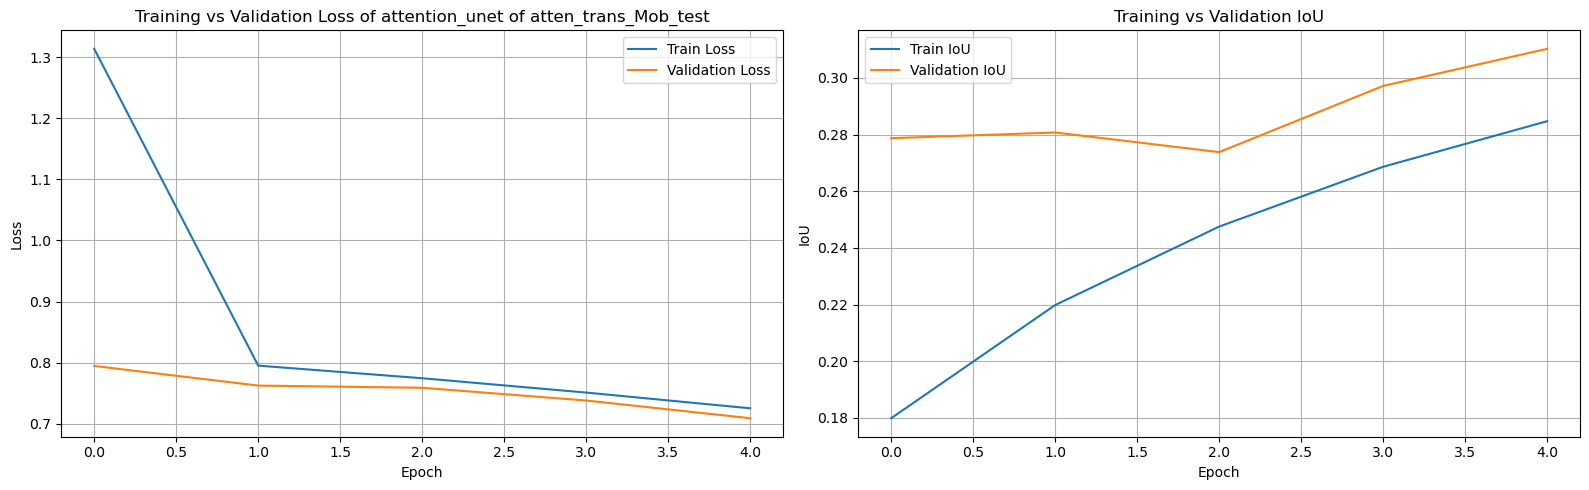

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = 'models/atten_trans_Mob_test/log.csv'
df = pd.read_csv(log_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))  

axes[0].plot(df['epoch'], df['loss'], label='Train Loss')
axes[0].plot(df['epoch'], df['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss of attention_unet of atten_trans_Mob_test')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df['epoch'], df['iou'], label='Train IoU')
axes[1].plot(df['epoch'], df['val_iou'], label='Validation IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training vs Validation IoU')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Learning rate curve

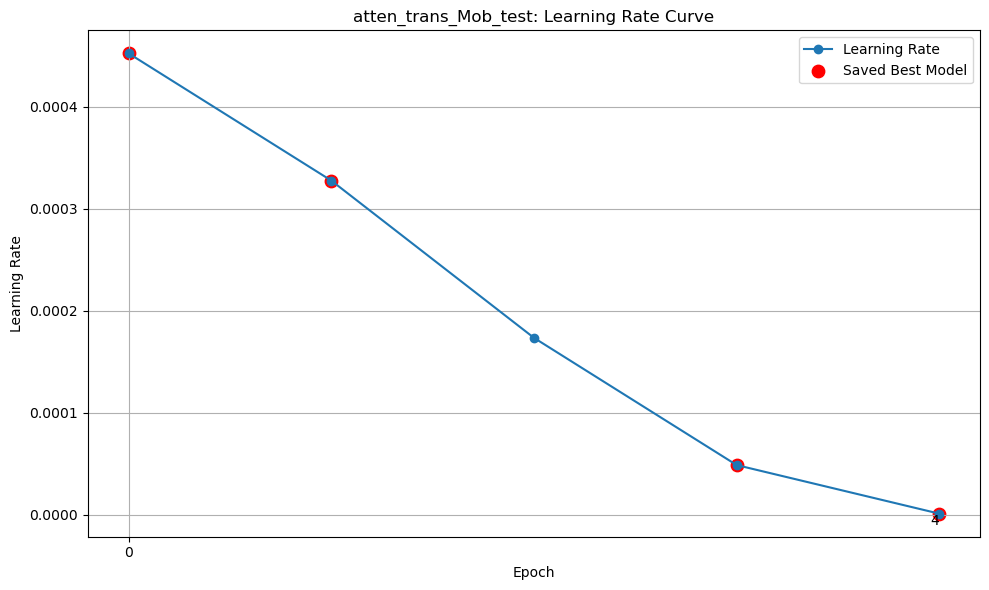

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv('models/atten_trans_Mob_test/log.csv')
epochs = log['epoch']
lrs = log['lr']
val_ious = log['val_iou']

best_epochs = []
best_so_far = -float('inf')
for i in range(len(val_ious)):
    if val_ious[i] > best_so_far:
        best_so_far = val_ious[i]
        best_epochs.append(i) 

plt.figure(figsize=(10, 6))
plt.plot(epochs, lrs, marker='o', label='Learning Rate')

max_epoch = epochs.max()
xticks = list(range(0, max_epoch + 1, 40))
plt.xticks(xticks)

plt.text(
    epochs.iloc[-1],
    lrs.iloc[-1] * 0.9,  
    f'{epochs.iloc[-1]}',
    color='black',
    fontsize=10,
    ha='right',
    va='top'
)

plt.scatter(epochs.iloc[best_epochs], lrs.iloc[best_epochs], 
            s=80, color='red', label='Saved Best Model')

# 图像美化
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('atten_trans_Mob_test: Learning Rate Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()